In [24]:
import os.path
import numpy as np

#Ensures we use Tensorflow 1.x
#%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_addons as tfa
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

import pandas as pd
from sklearn.linear_model import LinearRegression
from astropy.stats import median_absolute_deviation
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge

2.0.0


In [25]:
print(tf.__version__)
import tensorflow_addons as tfa

2.0.0


In [26]:
# rv_net imports.
import sys
sys.path.append("rv_net/")
from ops import training
from tf_util import config_util
from tf_util import configdict
from tf_util import estimator_runner
from rv_net import data_HARPS_N
from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps

In [27]:
# @title Residual plotting code
import matplotlib.pylab as mpl
def residual_plot(rv_list, x_axis, ccfs_of_interest, num_ref_ccf, plot_title):
    # create color scheme
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    # Create the residual plot by looping through the list of CCFs ordered by date
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            plt.plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0), color=colors[num])
        else:
            if i != num_ref_ccf:
                plt.plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1

    plt.title(plot_title)
    # make color bar
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=(min_rv - np.median(rv_list)), vmax=(max_rv - np.median(rv_list)))
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="vertical", pad=-0.0001)
    cb.set_label(label='Stellar Activity Signal (m/s)', size=16, rotation=270, labelpad=20)

## Reading in the data

In [28]:
eval_method ='cross_val' #"val"#'cross_val' #"val"# "val"#"cross_val" # "val" # "test"

ccf_len = 46

In [29]:
# Change this path to point towards the location of the files in your drive

!ls 'TF_records_Nov2021'

TF_ccf_cross_val0 TF_ccf_cross_val4 TF_ccf_cross_val8 TF_ccf_val
TF_ccf_cross_val1 TF_ccf_cross_val5 TF_ccf_cross_val9
TF_ccf_cross_val2 TF_ccf_cross_val6 TF_ccf_full_train
TF_ccf_cross_val3 TF_ccf_cross_val7 TF_ccf_test


In [30]:
# Read in files for cross-validation
DATA_DIR = 'TF_records_Nov2021/' #TF_record_July_10_21_no_planets_median_prov_rvs/' #HARPS-N Solar Telescope Data (using old DRS)/' #TF_record_July_10_21_no_planets_same_test_set' #TF_record_July_10_21_no_planets_v2'

if eval_method =="cross_val":
  data_files = tf.data.Dataset.list_files(DATA_DIR+'*cross_val*',shuffle=False)
  data_files = [t.numpy() for t in data_files]
  TRAIN_FILE_NAME_LIST = []
  VAL_FILE_NAME_LIST = []

  N = len(data_files)
  for i in range(N):
    val_files = [data_files[i]]
    #print(val_files)
    VAL_FILE_NAME_LIST.append(val_files)
    train_files = data_files[0:i] + data_files[i+1:]
    TRAIN_FILE_NAME_LIST.append(train_files)
    # add all the training files

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 51

elif eval_method =="val":
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_val")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61
elif eval_method =="test":
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61
else:
  print("Please select a valid evaluation method: 'cross_val' or 'val' or 'test'")

In [31]:
print(TRAIN_FILE_NAME_LIST)
VAL_FILE_NAME_LIST

[[b'TF_records_Nov2021/TF_ccf_cross_val1', b'TF_records_Nov2021/TF_ccf_cross_val2', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_records_Nov2021/TF_ccf_cross_val7', b'TF_records_Nov2021/TF_ccf_cross_val8', b'TF_records_Nov2021/TF_ccf_cross_val9'], [b'TF_records_Nov2021/TF_ccf_cross_val0', b'TF_records_Nov2021/TF_ccf_cross_val2', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_records_Nov2021/TF_ccf_cross_val7', b'TF_records_Nov2021/TF_ccf_cross_val8', b'TF_records_Nov2021/TF_ccf_cross_val9'], [b'TF_records_Nov2021/TF_ccf_cross_val0', b'TF_records_Nov2021/TF_ccf_cross_val1', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_recor

[[b'TF_records_Nov2021/TF_ccf_cross_val0'],
 [b'TF_records_Nov2021/TF_ccf_cross_val1'],
 [b'TF_records_Nov2021/TF_ccf_cross_val2'],
 [b'TF_records_Nov2021/TF_ccf_cross_val3'],
 [b'TF_records_Nov2021/TF_ccf_cross_val4'],
 [b'TF_records_Nov2021/TF_ccf_cross_val5'],
 [b'TF_records_Nov2021/TF_ccf_cross_val6'],
 [b'TF_records_Nov2021/TF_ccf_cross_val7'],
 [b'TF_records_Nov2021/TF_ccf_cross_val8'],
 [b'TF_records_Nov2021/TF_ccf_cross_val9']]

In [32]:
def _example_parser(serialized_example):
    """Parses a single tf.Example into feature and label tensors."""
    feature_name = "Rescaled CCF_residuals_cutoff"#"Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"#"RV",
    label2_name = "BJD"
    data_fields = {
        feature_name: tf.io.FixedLenFeature([ccf_len], tf.float32), #[161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name]

#def load_dataset(file_pattern, batch_size, mode=tf.estimator.ModeKeys.EVAL):
#  filename_dataset = tf.data.Dataset.list_files(file_pattern)
#  dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
#  if mode == tf.estimator.ModeKeys.TRAIN:
#    dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
#  dataset = dataset.map(_example_parser, num_parallel_calls=4)
#  dataset = dataset.batch(batch_size)
#  return dataset

def load_dataset(filenames, batch_size, mode=tf.estimator.ModeKeys.EVAL):
    filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
    dataset = dataset.map(_example_parser, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
    return dataset

In [33]:
# @title Define LinearModel, FCModel, CNNModel
class LinearModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(LinearModel, self).__init__()
        self.hparams = hparams
        #self.weights = tf.Variable(tf.zeros(self.hparams.num_features))
        self.dense_layer = tf.keras.layers.Dense(
            1, kernel_initializer=tf.zeros_initializer, use_bias=False)
        
    def call(self, features, training=False):
      # return tf.tensordot(features, self.weights, axes=1)
      return tf.squeeze(self.dense_layer(features))

class FCModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(FCModel, self).__init__()
        self.hparams = hparams
        #self.hidden_layer1 = tf.keras.layers.Dense(
        #    self.hparams.num_dense_units, activation=tf.keras.activations.relu)
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

# @title Define RVLinearModel
class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      for conv in self.conv_layers:
        net = conv(net)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

In [34]:
def make_predictions(model, dataset):
  all_preds = []
  all_labels = []
  all_bjds = []
  for features, labels, bjds in dataset:
    preds = model(features, training=False)
    all_preds.append(preds.numpy())
    all_labels.append(labels.numpy())
    all_bjds.append(bjds.numpy())
  return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train(model, hparams, plots, model_name, num_epochs):#=100):
  train_dataset = load_dataset([TRAIN_FILE_NAME], batch_size=hparams.batch_size, mode=tf.estimator.ModeKeys.TRAIN)
  val_dataset = load_dataset([VAL_FILE_NAME], batch_size=min(1024, NUM_VALIDATION_EXAMPLES), mode=tf.estimator.ModeKeys.EVAL)
  loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
  optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
  metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
  ]
  weight_decay_list_t.append(hparams.weight_decay)
  gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

  metric_values = []
  for epoch in range(1, num_epochs+1):
    # Reset metric values for each new epoch.
    for m in metrics:
      m.reset_states()

    # Train over all batches in the training set.
    for features, labels, bjds in train_dataset:
      if hparams.gaussian_noise_scale:
        features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
        #print(hparams.gaussian_noise_scale)
      # One training step.
      with tf.GradientTape() as t:
        preds = model(features, training=True)
        loss = loss_fn(labels, preds)
      grads = t.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # Update the metrics.
      for m in metrics:
        m(labels, preds)
    
    # End of an epoch.
    epoch_metrics = {"epoch": epoch}
    # First, log the training metrics.
    for m in metrics:
      epoch_metrics[m.name] = m.result().numpy()
    # Next, evaluate over the validation set.
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Add a metric for the raw scatter started with
    epoch_metrics["original_rmse"] = np.std(labels_val)
    # Add a metric for raw scatter - corrected scatter
    epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Log metrics to tensorboard.
    for metric, value in epoch_metrics.items():
      tf.summary.scalar(metric, value, step=epoch)
    epoch_metrics["epoch"] = epoch
    # Print metric values at selected epochs.
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
      print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
    metric_values.append(epoch_metrics)

  # Gather predictions
  labels, preds, bjd = make_predictions(model, train_dataset)
  labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
  all_bjds_val.append(bjd_val)
  bjd_run_val.append(bjd_val)
  all_pred_val.append(preds_val)
  pred_run_val.append(preds_val)
  all_labels_val.append(labels_val)
  labels_run_val.append(labels_val)

  # Scatter reduction plot
  sd_x = np.std(labels_val, ddof=1)
  rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
  rms_x_list.append(rms_x)
  rms_avg_list.append(rms_x)
  stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
  x_range = np.linspace(-4,5.5, 17)
  upper_bound = x_range+rms_x
  lower_bound = x_range-rms_x

  if plots=="ON":
    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    ax = axes[0]
    ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
    ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")

    # Gather predictions to plot against labels.
    ax = axes[1]
    ax.plot(preds, labels, ".", label="Training")
    ax.plot(preds_val, labels_val, ".", label="Validation")
    ax.set_xlabel("Actual Y")
    ax.set_ylabel("Predicted Y")
    ax.legend(loc="lower right")

    # plot the scatter reduction plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(labels_val, preds_val, ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 4);
    ax1.set_ylim(-4, 4);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")
  else:
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    print(textstr)
    
  return metric_values

# Ridge Regression

In [35]:
class DatasetBuilder(object):
    """Dataset builder class."""

    def __init__(self, file_pattern, hparams, mode, ccf_len, repeat=1):
        """Initializes the dataset builder.
        Args:
          file_pattern: File pattern matching input file shards, e.g.
            "/tmp/train-?????-of-00100".
          hparams: A ConfigDict.
          mode: A tf.estimator.ModeKeys.
          repeat: The number of times to repeat the dataset. If None, the dataset
            will repeat indefinitely.
        """
        valid_modes = [
            tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL,
            tf.estimator.ModeKeys.PREDICT
        ]
        if mode not in valid_modes:
            raise ValueError("Expected mode in {}. Got: {}".format(valid_modes, mode))

        self.file_pattern = file_pattern
        self.hparams = hparams
        self.mode = mode
        self.repeat = repeat
        self.ccf_len = ccf_len

    def __call__(self):
        is_training = self.mode == tf.estimator.ModeKeys.TRAIN

        # Dataset of file names.
        filename_dataset = tf.data.Dataset.list_files(self.file_pattern,
                                                      shuffle=is_training)

        # Dataset of serialized tf.Examples.
        dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)

        # Shuffle in training mode.
        if is_training:
            dataset = dataset.shuffle(self.hparams.shuffle_values_buffer)

        # Possibly repeat.
        if self.repeat != 1:
            dataset = dataset.repeat(self.repeat)

        def _example_parser(serialized_example):
            """Parses a single tf.Example into feature and label tensors."""
            data_fields = {
                self.hparams.ccf_feature_name: tf.io.FixedLenFeature([self.ccf_len], tf.float32),
                self.hparams.label_feature_name: tf.io.FixedLenFeature([], tf.float32),
                self.hparams.label_feature_name2: tf.io.FixedLenFeature([], tf.float32),
            }
            parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
            ccf_data = parsed_fields[self.hparams.ccf_feature_name]
            label = parsed_fields[self.hparams.label_feature_name]
            label *= self.hparams.label_rescale_factor  # Rescale the label.
            label2 = parsed_fields[self.hparams.label_feature_name2]
            return {
                "ccf_data": ccf_data,
                "label": label,
                "bjd": label2,
            }

        # Map the parser over the dataset.
        dataset = dataset.map(_example_parser, num_parallel_calls=4)

        # Batch results by up to batch_size.
        dataset = dataset.batch(self.hparams.batch_size)

        # Prefetch a few batches.
        dataset = dataset.prefetch(10)

        return dataset

In [36]:
def load_dataset_ridge(filename, ccf_len):
  dataset_hparams = configdict.ConfigDict(dict(
    ccf_feature_name='Rescaled CCF_residuals_cutoff',#"Rescaled CCF_residuals", #CCF_residuals
    label_feature_name= "activity signal",#"RV",
    label_feature_name2= "BJD",
    batch_size=300,
    label_rescale_factor=1000,
  ))
  dataset = DatasetBuilder(filename, dataset_hparams, tf.estimator.ModeKeys.EVAL, ccf_len)()
  batches = list(dataset)
  ccf_data, labels, bjds = zip(*[(batch["ccf_data"], batch["label"], batch["bjd"]) for batch in batches])
  ccf_data = np.concatenate(ccf_data)
  labels = np.concatenate(labels)
  bjds = np.concatenate(bjds)
  assert len(ccf_data.shape) == 2
  assert len(labels.shape) == 1
  assert len(bjds.shape) == 1
  assert ccf_data.shape[0] == labels.shape[0]
  #print("Read dataset with {} examples".format(labels.shape[0]))
  return ccf_data, labels, bjds

In [37]:
def ridge_regress_harps(TRAIN_FILE_NAME_LIST, VAL_FILE_NAME_LIST, alpha, verbose, ccf_len):
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []
  avg_list = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, ccf_len)
    val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, ccf_len)

    pred_run_val = []
    labels_run_val = []
    bjd_run_val = []
    for k in range(0,10):
      model = Ridge(alpha=alpha).fit(train_X, train_Y)
      val_pred_Y = model.predict(val_X)
      pred_run_val.append(val_pred_Y)
      labels_run_val.append(val_Y)
      bjd_run_val.append(val_bjd)
      rms_avg = np.sqrt(np.mean(np.square(val_Y -val_pred_Y)))
      rms_avg_list.append(rms_avg)
      if verbose == True:
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
        print("rms: "+str(rms_avg))
      else:
        continue
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  avg_list.append(avg)
  print("________________________")
  print("average rms = "+str(avg)+" m/s")

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]
  
  return all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_list, alpha

In [38]:
# Cross validation Ridge Regression Model Run (10 times)

all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_rms_list, alpha = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                 VAL_FILE_NAME_LIST, 
                                                                                 alpha=3.6094,#340.010636,#9.469, #340.010636,	#335.734079,#9.469, 
                                                                                 verbose=False,
                                                                                 ccf_len = 46)

________________________
average rms = 1.0802236 m/s


labels: sd: 1.8284893224673766
corrected rv: sd: 1.0849636105498959
____________________________________________
labels: MAD*1.4826: 1.7439013288736342
corrected rv: MAD*1.4826: 1.0854544334962963
____________________________________________
labels: 68 percent/2: 1.7452755212783813
corrected rv: 68 percent/2: 1.0970001339912414


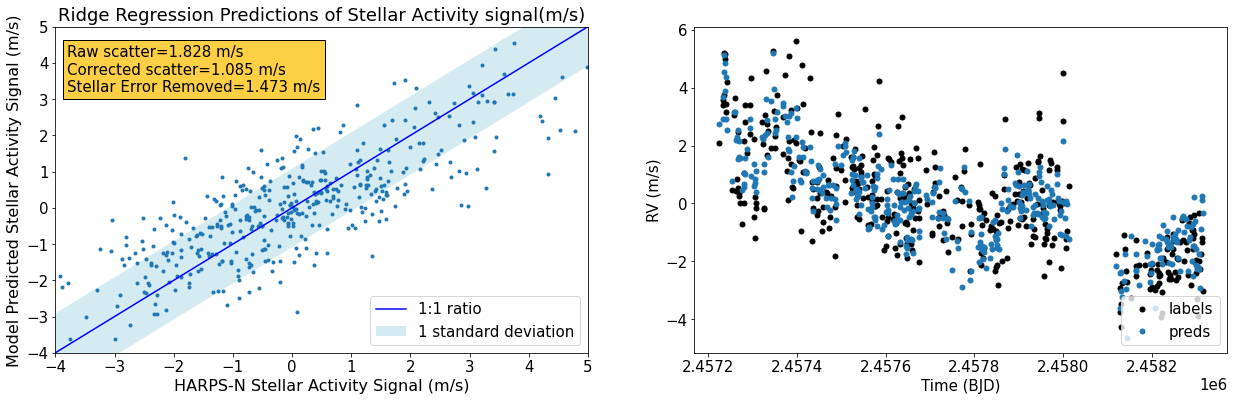

In [39]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_ridge_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("Ridge Regression Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (sd_labels, ),
    r'Corrected scatter=%.3f m/s' % (sd_corrected_rv, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 4.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

(-20.0, 20.0)

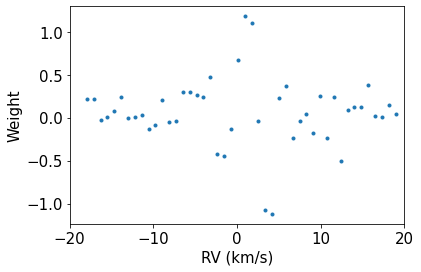

In [28]:
index=0
TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, 46)
val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, 46)
model = Ridge(alpha=alpha).fit(train_X, train_Y)
x_axis = np.linspace(-19.58, 19.78, 49)[2:48]
plt.plot(x_axis, model.coef_, ".")
plt.ylabel("Weight")
plt.xlabel("RV (km/s)")
plt.xlim(-20, 20)

In [29]:
# Alpha cross-val runs

# Cross validation Ridge Regression Model Run (10 times)
alpha_range = np.random.uniform(2, 5.5, 100)
#alpha_range = np.append(alpha_range, 9.469)

alpha_list = []
rms_crossval_list = []
for alpha in tqdm(alpha_range):
  all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_rms_list, alpha = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                  VAL_FILE_NAME_LIST, 
                                                                                  alpha=alpha, 
                                                                                  verbose=False,
                                                                                  ccf_len= 46)
  # compute rms across all crossval slice
  rms_crossval = np.mean(avg_rms_list)
  rms_crossval_list.append(rms_crossval)
  alpha_list.append(alpha)

  0%|          | 0/100 [00:00<?, ?it/s]

________________________
average rms = 1.0806684 m/s
________________________
average rms = 1.0806518 m/s
________________________
average rms = 1.0804646 m/s
________________________
average rms = 1.0812771 m/s
________________________
average rms = 1.0803189 m/s
________________________
average rms = 1.0817534 m/s
________________________
average rms = 1.0805019 m/s
________________________
average rms = 1.0811146 m/s
________________________
average rms = 1.0804687 m/s
________________________
average rms = 1.0813707 m/s
________________________
average rms = 1.080223 m/s
________________________
average rms = 1.0803183 m/s
________________________
average rms = 1.0805316 m/s
________________________
average rms = 1.0817243 m/s
________________________
average rms = 1.0802253 m/s
________________________
average rms = 1.0810616 m/s
________________________
average rms = 1.0802478 m/s
________________________
average rms = 1.0807314 m/s
________________________
average rms = 1.080512

In [41]:
df_rms = pd.DataFrame(list(zip(alpha_list, rms_crossval_list)), 
               columns =['alpha_list', 'avg_rms_list'])
df_rms_sorted = df_rms.sort_values(by=['avg_rms_list'])

folder = 'ridge_crossval_preds/'

if not os.path.isdir(folder):
        os.mkdir(folder)
        
df_rms_sorted.to_csv(folder+'alpha_rms_linear_12_6.csv', index = False) 

3.6602968950822814

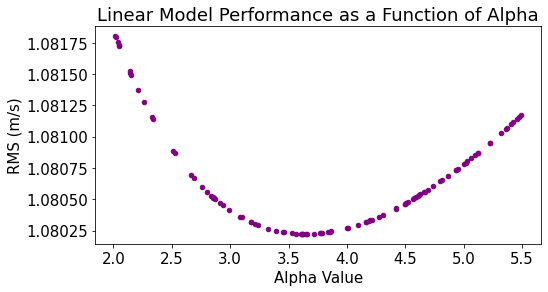

In [43]:
df_rms_sorted =pd.read_csv(folder+'alpha_rms_linear_12_6.csv')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.plot(df_rms_sorted["alpha_list"],df_rms_sorted["avg_rms_list"], ".", color='purple',
         markersize=9)
plt.title("Linear Model Performance as a Function of Alpha")
plt.xlabel("Alpha Value")
plt.ylabel("RMS (m/s)")
#plt.xlim(0, 20)
#plt.ylim(0.94, 0.95)

df_rms_sorted["alpha_list"][np.argmin(np.array(df_rms_sorted["avg_rms_list"]))]

In [48]:
# best alpha value
df_rms_sorted["alpha_list"][np.argmin(np.array(df_rms_sorted["avg_rms_list"]))]

3.6602968950822814

## FC NN Model Run

In [40]:
  # FC NN Model run

  # Cross validation Linear NN Model Run (10 times)
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,10): #should be 10 for a full run (this takes the average result over ten runs)
      hparams = configdict.ConfigDict(dict(
          num_features=49,#152,#161,
          learning_rate=0.012347,#0.0043815, #0.0095352,#0.0016077,
          momentum=0.9,
          batch_size=300,
          num_dense_units=200,#500,#200,
          num_dense_layers=4,
          weight_decay=0.0001,#0.00024022,#0.00010000, #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5, 
      ))
      model = FCModel(hparams)
      train(model, hparams, plots="OFF",model_name="FC NN", num_epochs=50)
      print(model)
      print("________________________")
      print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  print("________________________")
  print(avg)

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

1: Train loss: 3.089, Train RMSE: 1.844, Val RMSE: 1.47
10: Train loss: 0.9811, Train RMSE: 1.038, Val RMSE: 1.196
20: Train loss: 0.532, Train RMSE: 0.7466, Val RMSE: 1.165
30: Train loss: 0.3888, Train RMSE: 0.6576, Val RMSE: 1.225
40: Train loss: 0.1895, Train RMSE: 0.4788, Val RMSE: 1.426
50: Train loss: 0.09681, Train RMSE: 0.2917, Val RMSE: 1.309
Raw scatter=1.590 m/s
Corrected scatter=1.309 m/s
Stellar Error Removed=0.904 m/s
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.733, Train RMSE: 1.838, Val RMSE: 1.496
10: Train loss: 1.335, Train RMSE: 1.144, Val RMSE: 1.125
20: Train loss: 0.6987, Train RMSE: 0.8867, Val RMSE: 1.209
30: Train loss: 0.4377, Train RMSE: 0.6297, Val RMSE: 1.241
40: Train loss: 0.2792, Train RMSE: 0.4867, Val RMSE: 1.235
50: Train loss: 0.1076, Train RMSE: 0.3214, Val RMSE: 1.259
Raw scatter=1.590 m/s
Corrected scatter=1.259 m/s
Stellar Error Removed=0.972 m/s
________________________
Cross-val number: 1, Run number: 2
1: Tra

20: Train loss: 0.9638, Train RMSE: 1.084, Val RMSE: 1.364
30: Train loss: 0.4549, Train RMSE: 0.6602, Val RMSE: 1.225
40: Train loss: 0.1942, Train RMSE: 0.4354, Val RMSE: 1.132
50: Train loss: 0.09496, Train RMSE: 0.334, Val RMSE: 1.102
Raw scatter=1.861 m/s
Corrected scatter=1.102 m/s
Stellar Error Removed=1.499 m/s
________________________
Cross-val number: 2, Run number: 6
1: Train loss: 3.039, Train RMSE: 1.822, Val RMSE: 1.598
10: Train loss: 1.15, Train RMSE: 1.064, Val RMSE: 1.356
20: Train loss: 0.6116, Train RMSE: 0.7411, Val RMSE: 1.323
30: Train loss: 0.2796, Train RMSE: 0.4995, Val RMSE: 1.236
40: Train loss: 0.157, Train RMSE: 0.3903, Val RMSE: 1.302
50: Train loss: 0.0872, Train RMSE: 0.3018, Val RMSE: 1.342
Raw scatter=1.861 m/s
Corrected scatter=1.342 m/s
Stellar Error Removed=1.289 m/s
________________________
Cross-val number: 2, Run number: 7
1: Train loss: 3.123, Train RMSE: 1.931, Val RMSE: 1.708
10: Train loss: 1.15, Train RMSE: 1.066, Val RMSE: 1.262
20: Train 

40: Train loss: 0.2035, Train RMSE: 0.4562, Val RMSE: 1.169
50: Train loss: 0.1279, Train RMSE: 0.3671, Val RMSE: 1.141
Raw scatter=1.944 m/s
Corrected scatter=1.141 m/s
Stellar Error Removed=1.574 m/s
________________________
Cross-val number: 4, Run number: 1
1: Train loss: 3.592, Train RMSE: 1.764, Val RMSE: 1.767
10: Train loss: 1.245, Train RMSE: 1.109, Val RMSE: 1.183
20: Train loss: 0.7018, Train RMSE: 0.8195, Val RMSE: 1.098
30: Train loss: 0.5862, Train RMSE: 0.7857, Val RMSE: 1.144
40: Train loss: 0.2342, Train RMSE: 0.4994, Val RMSE: 1.043
50: Train loss: 0.09006, Train RMSE: 0.3242, Val RMSE: 1.072
Raw scatter=1.944 m/s
Corrected scatter=1.072 m/s
Stellar Error Removed=1.622 m/s
________________________
Cross-val number: 4, Run number: 2
1: Train loss: 3.181, Train RMSE: 1.813, Val RMSE: 1.611
10: Train loss: 1.308, Train RMSE: 1.058, Val RMSE: 1.319
20: Train loss: 0.8213, Train RMSE: 1.005, Val RMSE: 1.271
30: Train loss: 0.4153, Train RMSE: 0.6221, Val RMSE: 1.117
40: Tr

1: Train loss: 3.477, Train RMSE: 1.837, Val RMSE: 1.459
10: Train loss: 1.114, Train RMSE: 1.037, Val RMSE: 1.254
20: Train loss: 0.7236, Train RMSE: 0.8329, Val RMSE: 1.164
30: Train loss: 0.7731, Train RMSE: 0.8473, Val RMSE: 1.105
40: Train loss: 0.3155, Train RMSE: 0.5793, Val RMSE: 1.172
50: Train loss: 0.1301, Train RMSE: 0.3752, Val RMSE: 1.157
Raw scatter=1.737 m/s
Corrected scatter=1.157 m/s
Stellar Error Removed=1.295 m/s
________________________
Cross-val number: 5, Run number: 7
1: Train loss: 2.823, Train RMSE: 1.767, Val RMSE: 1.433
10: Train loss: 1.059, Train RMSE: 1.107, Val RMSE: 1.284
20: Train loss: 0.763, Train RMSE: 0.8826, Val RMSE: 1.252
30: Train loss: 0.4201, Train RMSE: 0.6669, Val RMSE: 1.184
40: Train loss: 0.2155, Train RMSE: 0.482, Val RMSE: 1.191
50: Train loss: 0.1253, Train RMSE: 0.3645, Val RMSE: 1.198
Raw scatter=1.737 m/s
Corrected scatter=1.198 m/s
Stellar Error Removed=1.257 m/s
________________________
Cross-val number: 5, Run number: 8
1: Train

20: Train loss: 0.7908, Train RMSE: 0.8413, Val RMSE: 1.086
30: Train loss: 0.3302, Train RMSE: 0.5688, Val RMSE: 1.13
40: Train loss: 0.1602, Train RMSE: 0.3837, Val RMSE: 1.105
50: Train loss: 0.2086, Train RMSE: 0.474, Val RMSE: 1.106
Raw scatter=1.312 m/s
Corrected scatter=1.106 m/s
Stellar Error Removed=0.706 m/s
________________________
Cross-val number: 7, Run number: 2
1: Train loss: 3.507, Train RMSE: 1.876, Val RMSE: 1.236
10: Train loss: 1.26, Train RMSE: 1.135, Val RMSE: 1.109
20: Train loss: 0.7726, Train RMSE: 0.9026, Val RMSE: 1.125
30: Train loss: 0.5315, Train RMSE: 0.8021, Val RMSE: 1.11
40: Train loss: 0.2668, Train RMSE: 0.5058, Val RMSE: 1.12
50: Train loss: 0.1229, Train RMSE: 0.3393, Val RMSE: 1.084
Raw scatter=1.312 m/s
Corrected scatter=1.084 m/s
Stellar Error Removed=0.740 m/s
________________________
Cross-val number: 7, Run number: 3
1: Train loss: 2.91, Train RMSE: 1.821, Val RMSE: 1.269
10: Train loss: 1.051, Train RMSE: 1.108, Val RMSE: 1.037
20: Train lo

40: Train loss: 0.1838, Train RMSE: 0.4541, Val RMSE: 1.203
50: Train loss: 0.1931, Train RMSE: 0.4638, Val RMSE: 1.234
Raw scatter=1.897 m/s
Corrected scatter=1.234 m/s
Stellar Error Removed=1.440 m/s
________________________
Cross-val number: 8, Run number: 7
1: Train loss: 3.345, Train RMSE: 1.854, Val RMSE: 1.55
10: Train loss: 1.15, Train RMSE: 1.053, Val RMSE: 1.231
20: Train loss: 0.6407, Train RMSE: 0.816, Val RMSE: 1.241
30: Train loss: 0.4517, Train RMSE: 0.7256, Val RMSE: 1.28
40: Train loss: 0.1789, Train RMSE: 0.431, Val RMSE: 1.143
50: Train loss: 0.0801, Train RMSE: 0.2956, Val RMSE: 1.163
Raw scatter=1.897 m/s
Corrected scatter=1.163 m/s
Stellar Error Removed=1.498 m/s
________________________
Cross-val number: 8, Run number: 8
1: Train loss: 3.19, Train RMSE: 1.781, Val RMSE: 1.656
10: Train loss: 1.164, Train RMSE: 1.095, Val RMSE: 1.233
20: Train loss: 0.744, Train RMSE: 0.8418, Val RMSE: 1.1
30: Train loss: 0.3637, Train RMSE: 0.647, Val RMSE: 1.18
40: Train loss: 0

1: Train loss: 3.501, Train RMSE: 1.868, Val RMSE: 1.744
10: Train loss: 1.179, Train RMSE: 1.095, Val RMSE: 1.179
20: Train loss: 0.6407, Train RMSE: 0.8321, Val RMSE: 0.9869
30: Train loss: 0.4008, Train RMSE: 0.6499, Val RMSE: 1.006
40: Train loss: 0.1729, Train RMSE: 0.4063, Val RMSE: 1.035
50: Train loss: 0.1163, Train RMSE: 0.3294, Val RMSE: 1.029
Raw scatter=1.947 m/s
Corrected scatter=1.029 m/s
Stellar Error Removed=1.653 m/s
________________________
Cross-val number: 10, Run number: 3
1: Train loss: 2.97, Train RMSE: 1.8, Val RMSE: 1.646
10: Train loss: 1.28, Train RMSE: 1.089, Val RMSE: 1.156
20: Train loss: 0.7074, Train RMSE: 0.8117, Val RMSE: 1.022
30: Train loss: 0.3124, Train RMSE: 0.5778, Val RMSE: 1.098
40: Train loss: 0.158, Train RMSE: 0.41, Val RMSE: 1.061
50: Train loss: 0.1402, Train RMSE: 0.3806, Val RMSE: 1.034
Raw scatter=1.947 m/s
Corrected scatter=1.034 m/s
Stellar Error Removed=1.650 m/s
________________________
Cross-val number: 10, Run number: 4
1: Train l

labels: sd: 1.8284893224673766
corrected rv: sd: 1.089442427201717
____________________________________________
labels: MAD*1.4826: 1.7439013288736342
corrected rv: MAD*1.4826: 1.091289980484545
____________________________________________
labels: 68 percent/2: 1.7452755212783813
corrected rv: 68 percent/2: 1.0720969367027284


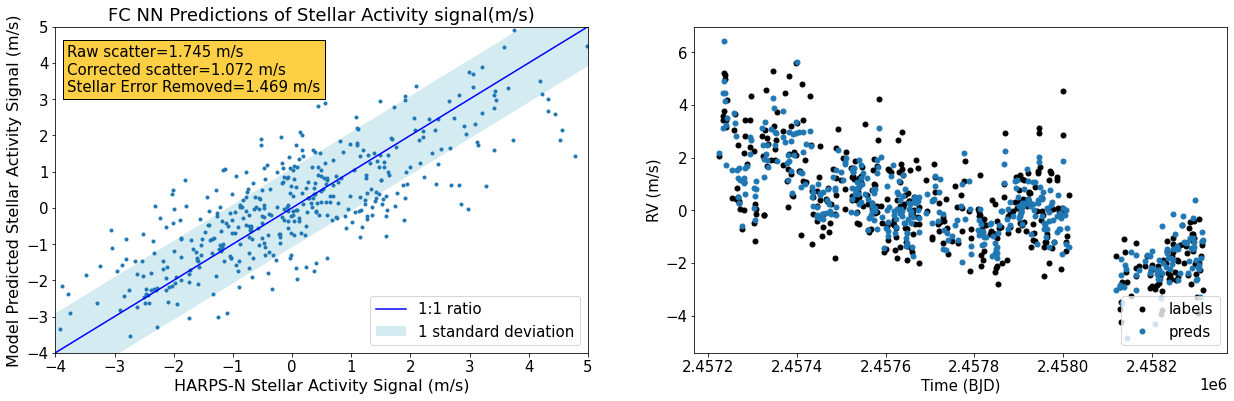

In [43]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_FCNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("FC NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 4.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

## CNN Model Run

In [ ]:
# CNN Model run

# Cross validation CNN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []
all_mean_val_bjds = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
  TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
  VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
  bjd_run_val = []
  pred_run_val = []
  labels_run_val = []
  for k in range(0,10): #should be 10 for a full run
    hparams = configdict.ConfigDict(dict(
        num_features=152,
        learning_rate=0.0050618, #1e-3,
        momentum=0.9,
        batch_size=300,
        conv_kernel_size=3,
        num_conv_filters=32,
        num_conv_layers=4,
        num_dense_units=500,
        num_dense_layers=1,
        weight_decay=0.0012341, #5e-4, #7e-2,
        gaussian_noise_scale=0,#1.5,
    ))
    model = CNNModel(hparams)
    train(model, hparams, plots="OFF",model_name="CNN", num_epochs=35)#65)
    print(model)
    print("________________________")
    print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
  mean_val_preds = np.mean(pred_run_val, axis=0)
  mean_val_labels = np.mean(labels_run_val, axis=0)
  mean_val_bjds = np.mean(bjd_run_val, axis=0)
  all_mean_val_preds.append(mean_val_preds.tolist())
  all_mean_val_labels.append(mean_val_labels.tolist())
  all_mean_val_bjds.append(mean_val_bjds.tolist())
avg = np.mean(rms_avg_list)
print("________________________")
print(avg)

#flatten the lists
all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

In [ ]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_CNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("CNN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")


# FC NN Optimize Hyperparameters (08.31.21)

In [19]:
from tensorboard.plugins.hparams import api as hp
import shutil
import time

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [203]:
# Define the ranges of values that each hyperparameter can take

x = np.random.uniform(1,5, 1000)
learning_rate_list = [10**-x][0]

dense_units_list = [100, 200, 500, 1000]
num_dense_layers_list = [4, 8, 12, 16] #[1, 2, 4, 8, 12, 16]
weight_decay_list = np.geomspace(0.0001, 0.008, 6)

num_epochs_list = [30, 35, 40, 45, 50] #[50, 55, 65, 70, 80, 90, 100]

In [ ]:
# series code

LOG_DIR_1 = "gdrive/Shareddrives/Exoplanet_RV/logs/" + time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(LOG_DIR_1)

# Log the hparam config. This is optional but makes tensorboard show the right ranges.
with tf.summary.create_file_writer(LOG_DIR_1).as_default():
  hp.hparams_config(
    hparams=[
             hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
             hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
             hp.HParam('num_dense_layers', hp.Discrete([4, 8, 12, 16])),
             hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2))],
    metrics=[hp.Metric("val_rmse", display_name='RMSE'),
             hp.Metric("original_rmse", display_name="OG RMSE"),
             hp.Metric("difference_rmse", display_name="diff RMSE"),
            ],
  )

model_num = 1
RMSE_list = []
all_pred_bjd_val = []

rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []

for s in range(0, 1):#len(VAL_FILE_NAME_LIST)):
  #TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
  #VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
  ts = time.time()
  for i in range(0,300):#30):
      hparams = configdict.ConfigDict(dict(
          num_features=46,
          learning_rate=np.random.choice(learning_rate_list),
          momentum=0.9,
          batch_size=1024,
          num_dense_units=int(np.random.choice(dense_units_list)),
          num_dense_layers=int(np.random.choice(num_dense_layers_list)),
          weight_decay=np.random.choice(weight_decay_list), #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5,
      ))
      epochs = np.random.choice(num_epochs_list)
      for index in range(0, len(VAL_FILE_NAME_LIST)):
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]

        bjd_run_val = []
        pred_run_val = []
        labels_run_val = []
        k=0
        #for k in range(0,1):
        print("Model {}. Learning_rate: {:.5f}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
              model_num, hparams.learning_rate, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
        print("Cross-val number: "+str(index+1)+", Model archictect. num: "+str(i+1)+", Run number: "+str(k+1))
        model = FCModel(hparams)
        run_dir = LOG_DIR_1 + "/{}/".format(model_num)
        with tf.summary.create_file_writer(run_dir).as_default():
          hp.hparams(hparams)  # record the values used in this trial
          metric_values = train(model, hparams, plots="OFF", model_name = "FC NN",num_epochs=epochs)
          final_metrics = metric_values[-1]

        print("________________________")
        print()
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)

        all_mean_val_preds.append(mean_val_preds)
        all_mean_val_labels.append(mean_val_labels)
        all_mean_val_bjds.append(mean_val_bjds)

        all_pred_val.append(pred_run_val)
        all_labels_val.append(labels_run_val)
        all_bjds_val.append(bjd_run_val)
      model_num += 1

print('Time in series:', time.time() - ts)


gdrive/Shareddrives/Exoplanet_RV/logs/20211206-233716
Model 1. Learning_rate: 0.00804. Dense units: 500. Dense layers 8. Weight decay: 0.00010
Cross-val number: 1, Model archictect. num: 1, Run number: 1
1: Train loss: 3.396, Train RMSE: 1.843, Val RMSE: 1.58
10: Train loss: 2.124, Train RMSE: 1.457, Val RMSE: 1.456
20: Train loss: 1.587, Train RMSE: 1.26, Val RMSE: 1.24
30: Train loss: 1.19, Train RMSE: 1.091, Val RMSE: 1.194
40: Train loss: 0.8273, Train RMSE: 0.9096, Val RMSE: 1.161
45: Train loss: 0.6372, Train RMSE: 0.7982, Val RMSE: 1.215
Raw scatter=1.590 m/s
Corrected scatter=1.215 m/s
Stellar Error Removed=1.026 m/s
________________________

Model 1. Learning_rate: 0.00804. Dense units: 500. Dense layers 8. Weight decay: 0.00010
Cross-val number: 2, Model archictect. num: 1, Run number: 1
1: Train loss: 3.346, Train RMSE: 1.829, Val RMSE: 1.838
10: Train loss: 2.566, Train RMSE: 1.602, Val RMSE: 1.647
20: Train loss: 1.448, Train RMSE: 1.203, Val RMSE: 1.486
30: Train loss: 1.

20: Train loss: 2.908, Train RMSE: 1.705, Val RMSE: 1.788
30: Train loss: 2.716, Train RMSE: 1.648, Val RMSE: 1.749
40: Train loss: 2.574, Train RMSE: 1.604, Val RMSE: 1.715
45: Train loss: 2.516, Train RMSE: 1.586, Val RMSE: 1.7
Raw scatter=1.944 m/s
Corrected scatter=1.700 m/s
Stellar Error Removed=0.944 m/s
________________________

Model 2. Learning_rate: 0.00010. Dense units: 1000. Dense layers 4. Weight decay: 0.00139
Cross-val number: 5, Model archictect. num: 2, Run number: 1
1: Train loss: 3.431, Train RMSE: 1.852, Val RMSE: 1.735
10: Train loss: 3.319, Train RMSE: 1.822, Val RMSE: 1.702
20: Train loss: 3.121, Train RMSE: 1.767, Val RMSE: 1.65
30: Train loss: 2.944, Train RMSE: 1.716, Val RMSE: 1.603
40: Train loss: 2.802, Train RMSE: 1.674, Val RMSE: 1.564
45: Train loss: 2.742, Train RMSE: 1.656, Val RMSE: 1.547
Raw scatter=1.737 m/s
Corrected scatter=1.547 m/s
Stellar Error Removed=0.789 m/s
________________________

Model 2. Learning_rate: 0.00010. Dense units: 1000. Dense

1: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.874
10: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.874
20: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.874
30: Train loss: 3.322, Train RMSE: 1.823, Val RMSE: 1.873
40: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.873
45: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.873
Raw scatter=1.897 m/s
Corrected scatter=1.873 m/s
Stellar Error Removed=0.297 m/s
________________________

Model 3. Learning_rate: 0.00003. Dense units: 200. Dense layers 16. Weight decay: 0.00058
Cross-val number: 9, Model archictect. num: 3, Run number: 1
1: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.92
10: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.92
20: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.92
30: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.92
40: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.92
45: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.92
Raw scatter=1.846 m/s
Corrected scatter=1.920 m/s
Ste

45: Train loss: 3.224, Train RMSE: 1.796, Val RMSE: 2.064
Raw scatter=2.087 m/s
Corrected scatter=2.064 m/s
Stellar Error Removed=0.308 m/s
________________________

Model 5. Learning_rate: 0.00032. Dense units: 200. Dense layers 16. Weight decay: 0.00058
Cross-val number: 4, Model archictect. num: 5, Run number: 1
1: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.935
10: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.935
20: Train loss: 3.286, Train RMSE: 1.813, Val RMSE: 1.936
30: Train loss: 3.282, Train RMSE: 1.811, Val RMSE: 1.936
40: Train loss: 3.277, Train RMSE: 1.81, Val RMSE: 1.937
45: Train loss: 3.275, Train RMSE: 1.81, Val RMSE: 1.937
Raw scatter=1.944 m/s
Corrected scatter=1.937 m/s
Stellar Error Removed=0.164 m/s
________________________

Model 5. Learning_rate: 0.00032. Dense units: 200. Dense layers 16. Weight decay: 0.00058
Cross-val number: 5, Model archictect. num: 5, Run number: 1
1: Train loss: 3.383, Train RMSE: 1.839, Val RMSE: 1.727
10: Train loss: 3.381,

1: Train loss: 3.184, Train RMSE: 1.784, Val RMSE: 1.809
10: Train loss: 1.794, Train RMSE: 1.339, Val RMSE: 1.205
20: Train loss: 1.495, Train RMSE: 1.223, Val RMSE: 1.149
30: Train loss: 1.276, Train RMSE: 1.13, Val RMSE: 1.08
Raw scatter=1.846 m/s
Corrected scatter=1.080 m/s
Stellar Error Removed=1.498 m/s
________________________

Model 6. Learning_rate: 0.00291. Dense units: 500. Dense layers 4. Weight decay: 0.00058
Cross-val number: 10, Model archictect. num: 6, Run number: 1
1: Train loss: 3.437, Train RMSE: 1.854, Val RMSE: 1.942
10: Train loss: 1.801, Train RMSE: 1.342, Val RMSE: 1.44
20: Train loss: 1.535, Train RMSE: 1.239, Val RMSE: 1.275
30: Train loss: 1.288, Train RMSE: 1.135, Val RMSE: 1.231
Raw scatter=1.947 m/s
Corrected scatter=1.231 m/s
Stellar Error Removed=1.509 m/s
________________________

Model 7. Learning_rate: 0.00002. Dense units: 1000. Dense layers 8. Weight decay: 0.00800
Cross-val number: 1, Model archictect. num: 7, Run number: 1
1: Train loss: 3.457, T

1: Train loss: 3.392, Train RMSE: 1.842, Val RMSE: 2.01
10: Train loss: 2.894, Train RMSE: 1.701, Val RMSE: 1.851
20: Train loss: 2.236, Train RMSE: 1.495, Val RMSE: 1.636
30: Train loss: 1.809, Train RMSE: 1.345, Val RMSE: 1.442
40: Train loss: 1.62, Train RMSE: 1.273, Val RMSE: 1.306
45: Train loss: 1.583, Train RMSE: 1.258, Val RMSE: 1.272
Raw scatter=1.944 m/s
Corrected scatter=1.272 m/s
Stellar Error Removed=1.471 m/s
________________________

Model 8. Learning_rate: 0.00065. Dense units: 100. Dense layers 4. Weight decay: 0.00139
Cross-val number: 5, Model archictect. num: 8, Run number: 1
1: Train loss: 3.608, Train RMSE: 1.899, Val RMSE: 1.761
10: Train loss: 2.558, Train RMSE: 1.6, Val RMSE: 1.464
20: Train loss: 2.07, Train RMSE: 1.439, Val RMSE: 1.325
30: Train loss: 1.76, Train RMSE: 1.327, Val RMSE: 1.254
40: Train loss: 1.656, Train RMSE: 1.287, Val RMSE: 1.253
45: Train loss: 1.619, Train RMSE: 1.272, Val RMSE: 1.248
Raw scatter=1.737 m/s
Corrected scatter=1.248 m/s
Stel

30: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.874
40: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.874
Raw scatter=1.897 m/s
Corrected scatter=1.874 m/s
Stellar Error Removed=0.293 m/s
________________________

Model 9. Learning_rate: 0.00001. Dense units: 500. Dense layers 16. Weight decay: 0.00800
Cross-val number: 9, Model archictect. num: 9, Run number: 1
1: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.921
10: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.922
20: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.922
30: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.922
40: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.922
Raw scatter=1.846 m/s
Corrected scatter=1.922 m/s
Stellar Error Removed=0.533 m/s
________________________

Model 9. Learning_rate: 0.00001. Dense units: 500. Dense layers 16. Weight decay: 0.00800
Cross-val number: 10, Model archictect. num: 9, Run number: 1
1: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.928
10: Train loss: 3.3

10: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.839
20: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.839
30: Train loss: 3.337, Train RMSE: 1.827, Val RMSE: 1.839
40: Train loss: 3.337, Train RMSE: 1.827, Val RMSE: 1.838
50: Train loss: 3.336, Train RMSE: 1.827, Val RMSE: 1.838
Raw scatter=1.861 m/s
Corrected scatter=1.838 m/s
Stellar Error Removed=0.286 m/s
________________________

Model 11. Learning_rate: 0.00002. Dense units: 500. Dense layers 16. Weight decay: 0.00058
Cross-val number: 3, Model archictect. num: 11, Run number: 1
1: Train loss: 3.238, Train RMSE: 1.8, Val RMSE: 2.069
10: Train loss: 3.238, Train RMSE: 1.799, Val RMSE: 2.069
20: Train loss: 3.238, Train RMSE: 1.799, Val RMSE: 2.069
30: Train loss: 3.238, Train RMSE: 1.799, Val RMSE: 2.069
40: Train loss: 3.237, Train RMSE: 1.799, Val RMSE: 2.069
50: Train loss: 3.237, Train RMSE: 1.799, Val RMSE: 2.069
Raw scatter=2.087 m/s
Corrected scatter=2.069 m/s
Stellar Error Removed=0.276 m/s
______________________

1: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.964
10: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.963
20: Train loss: 3.284, Train RMSE: 1.812, Val RMSE: 1.961
30: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.96
40: Train loss: 3.277, Train RMSE: 1.81, Val RMSE: 1.958
45: Train loss: 3.276, Train RMSE: 1.81, Val RMSE: 1.958
Raw scatter=1.954 m/s
Corrected scatter=1.958 m/s
Stellar Error Removed=0.124 m/s
________________________

Model 12. Learning_rate: 0.00015. Dense units: 200. Dense layers 12. Weight decay: 0.00139
Cross-val number: 7, Model archictect. num: 12, Run number: 1
1: Train loss: 3.516, Train RMSE: 1.875, Val RMSE: 1.32
10: Train loss: 3.514, Train RMSE: 1.874, Val RMSE: 1.321
20: Train loss: 3.509, Train RMSE: 1.873, Val RMSE: 1.322
30: Train loss: 3.505, Train RMSE: 1.872, Val RMSE: 1.323
40: Train loss: 3.502, Train RMSE: 1.871, Val RMSE: 1.324
45: Train loss: 3.501, Train RMSE: 1.871, Val RMSE: 1.325
Raw scatter=1.312 m/s
Corrected scatter=1.325 m/s


40: Train loss: 1.114, Train RMSE: 1.055, Val RMSE: 1.095
Raw scatter=1.947 m/s
Corrected scatter=1.095 m/s
Stellar Error Removed=1.610 m/s
________________________

Model 14. Learning_rate: 0.00028. Dense units: 100. Dense layers 4. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 14, Run number: 1
1: Train loss: 3.07, Train RMSE: 1.752, Val RMSE: 1.645
10: Train loss: 2.867, Train RMSE: 1.693, Val RMSE: 1.584
20: Train loss: 2.521, Train RMSE: 1.588, Val RMSE: 1.499
30: Train loss: 2.237, Train RMSE: 1.496, Val RMSE: 1.434
40: Train loss: 2.038, Train RMSE: 1.428, Val RMSE: 1.389
Raw scatter=1.590 m/s
Corrected scatter=1.389 m/s
Stellar Error Removed=0.775 m/s
________________________

Model 14. Learning_rate: 0.00028. Dense units: 100. Dense layers 4. Weight decay: 0.00139
Cross-val number: 2, Model archictect. num: 14, Run number: 1
1: Train loss: 3.344, Train RMSE: 1.829, Val RMSE: 1.809
10: Train loss: 3.052, Train RMSE: 1.747, Val RMSE: 1.749
20: Train loss: 2.6

1: Train loss: 3.375, Train RMSE: 1.837, Val RMSE: 1.724
10: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.691
20: Train loss: 2.812, Train RMSE: 1.677, Val RMSE: 1.532
30: Train loss: 1.825, Train RMSE: 1.351, Val RMSE: 1.363
40: Train loss: 1.186, Train RMSE: 1.089, Val RMSE: 1.274
50: Train loss: 0.8413, Train RMSE: 0.9172, Val RMSE: 1.206
Raw scatter=1.737 m/s
Corrected scatter=1.206 m/s
Stellar Error Removed=1.250 m/s
________________________

Model 15. Learning_rate: 0.00547. Dense units: 200. Dense layers 12. Weight decay: 0.00024
Cross-val number: 6, Model archictect. num: 15, Run number: 1
1: Train loss: 3.285, Train RMSE: 1.813, Val RMSE: 1.962
10: Train loss: 3.22, Train RMSE: 1.794, Val RMSE: 1.934
20: Train loss: 2.889, Train RMSE: 1.7, Val RMSE: 1.802
30: Train loss: 1.736, Train RMSE: 1.318, Val RMSE: 1.548
40: Train loss: 1.45, Train RMSE: 1.204, Val RMSE: 1.382
50: Train loss: 1.105, Train RMSE: 1.051, Val RMSE: 1.364
Raw scatter=1.954 m/s
Corrected scatter=1.364 m

30: Train loss: 0.892, Train RMSE: 0.9444, Val RMSE: 0.9626
40: Train loss: 0.6499, Train RMSE: 0.8062, Val RMSE: 0.9729
Raw scatter=1.846 m/s
Corrected scatter=0.973 m/s
Stellar Error Removed=1.569 m/s
________________________

Model 16. Learning_rate: 0.01579. Dense units: 100. Dense layers 4. Weight decay: 0.00010
Cross-val number: 10, Model archictect. num: 16, Run number: 1
1: Train loss: 3.198, Train RMSE: 1.788, Val RMSE: 1.729
10: Train loss: 1.472, Train RMSE: 1.213, Val RMSE: 1.298
20: Train loss: 1.055, Train RMSE: 1.027, Val RMSE: 1.122
30: Train loss: 0.7378, Train RMSE: 0.859, Val RMSE: 1.054
40: Train loss: 0.4642, Train RMSE: 0.6813, Val RMSE: 1.063
Raw scatter=1.947 m/s
Corrected scatter=1.063 m/s
Stellar Error Removed=1.631 m/s
________________________

Model 17. Learning_rate: 0.09937. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 17, Run number: 1
1: Train loss: 3.438, Train RMSE: 1.854, Val RMSE: 1.561
10: Train

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=2.087 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 17. Learning_rate: 0.09937. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 4, Model archictect. num: 17, Run number: 1
1: Train loss: 3.319, Train RMSE: 1.822, Val RMSE: 1.91
10: Train loss: 3.61, Train RMSE: 1.9, Val RMSE: 4.265
20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.944 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 17. Learning_rate: 0.09937. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 5, Model archictect. num: 17, Run number: 1
1: Train loss: 3.375, Train RMSE: 1.837, Val RMSE: 1.645
10: Train loss: 3.403, Train RMSE: 1.845, Val RMSE: 1.707
20: Train loss: 3.233, Train RMSE: 1.798, Val RMSE: 2.

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.312 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 17. Learning_rate: 0.09937. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 8, Model archictect. num: 17, Run number: 1
1: Train loss: 3.357, Train RMSE: 1.832, Val RMSE: 1.825
10: Train loss: 2.825, Train RMSE: 1.681, Val RMSE: 2.023
20: Train loss: 4.096, Train RMSE: 2.024, Val RMSE: 1.867
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.897 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 17. Learning_rate: 0.09937. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 9, Model archictect. num: 17, Run number: 1
1: Train loss: 3.261, Train RMSE: 1.806, Val RMSE: 1.776
10: Train loss: 3.27, Train RMSE: 1.808, Val RMSE: 2.172
20: Train loss: 3.316, Train RMSE: 1.821, Val

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.846 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 17. Learning_rate: 0.09937. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 17, Run number: 1
1: Train loss: 3.34, Train RMSE: 1.827, Val RMSE: 1.885


ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


10: Train loss: nan, Train RMSE: nan, Val RMSE: nan
20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.947 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 18, Run number: 1
1: Train loss: 3.497, Train RMSE: 1.87, Val RMSE: 1.663
10: Train loss: 2.101, Train RMSE: 1.449, Val RMSE: 1.666
20: Train loss: 4.166, Train RMSE: 2.041, Val RMSE: 1.579
30: Train loss: 3.04, Train RMSE: 1.744, Val RMSE: 2.15
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.590 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 2, Model archictect. num: 18, Run number: 1
1: Train loss: 3.389, Train RMSE: 1.841, Val RMSE: 1

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


20: Train loss: 2.004e+08, Train RMSE: 1.416e+04, Val RMSE: inf
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.861 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 3, Model archictect. num: 18, Run number: 1
1: Train loss: 3.089, Train RMSE: 1.758, Val RMSE: 1.389
10: Train loss: 3.092, Train RMSE: 1.758, Val RMSE: 1.857
20: Train loss: 2.704, Train RMSE: 1.644, Val RMSE: 2.151
30: Train loss: 2.221, Train RMSE: 1.49, Val RMSE: 1.675
40: Train loss: 3.252, Train RMSE: 1.803, Val RMSE: 1.771
Raw scatter=2.087 m/s
Corrected scatter=1.771 m/s
Stellar Error Removed=1.104 m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 4, Model archictect. num: 18, Run number: 1
1: Train loss: 3.38, Train R

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.954 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 7, Model archictect. num: 18, Run number: 1
1: Train loss: 3.586, Train RMSE: 1.894, Val RMSE: 1.237


ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


10: Train loss: nan, Train RMSE: nan, Val RMSE: nan
20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.312 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 8, Model archictect. num: 18, Run number: 1
1: Train loss: 3.431, Train RMSE: 1.852, Val RMSE: 1.698
10: Train loss: 1.323, Train RMSE: 1.15, Val RMSE: 1.243
20: Train loss: 1.901, Train RMSE: 1.379, Val RMSE: 2.013
30: Train loss: 3.597, Train RMSE: 1.897, Val RMSE: 1.764
40: Train loss: 3.317, Train RMSE: 1.821, Val RMSE: 1.536
Raw scatter=1.897 m/s
Corrected scatter=1.536 m/s
Stellar Error Removed=1.112 m/s
________________________

Model 18. Learning_rate: 0.08021. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 9, Model archictect. num: 18, Ru

10: Train loss: 1.989, Train RMSE: 1.41, Val RMSE: 1.421
20: Train loss: 1.554, Train RMSE: 1.247, Val RMSE: 1.282
30: Train loss: 1.347, Train RMSE: 1.161, Val RMSE: 1.221
40: Train loss: 1.173, Train RMSE: 1.083, Val RMSE: 1.218
45: Train loss: 1.113, Train RMSE: 1.055, Val RMSE: 1.239
Raw scatter=1.590 m/s
Corrected scatter=1.239 m/s
Stellar Error Removed=0.997 m/s
________________________

Model 20. Learning_rate: 0.00451. Dense units: 100. Dense layers 4. Weight decay: 0.00333
Cross-val number: 2, Model archictect. num: 20, Run number: 1
1: Train loss: 3.393, Train RMSE: 1.842, Val RMSE: 1.839
10: Train loss: 1.627, Train RMSE: 1.275, Val RMSE: 1.641
20: Train loss: 1.493, Train RMSE: 1.222, Val RMSE: 1.487
30: Train loss: 1.307, Train RMSE: 1.143, Val RMSE: 1.487
40: Train loss: 1.201, Train RMSE: 1.096, Val RMSE: 1.427
45: Train loss: 1.162, Train RMSE: 1.078, Val RMSE: 1.419
Raw scatter=1.861 m/s
Corrected scatter=1.419 m/s
Stellar Error Removed=1.203 m/s
______________________

1: Train loss: 3.348, Train RMSE: 1.83, Val RMSE: 1.687
10: Train loss: 1.861, Train RMSE: 1.364, Val RMSE: 1.267
20: Train loss: 1.593, Train RMSE: 1.262, Val RMSE: 1.256
30: Train loss: 1.469, Train RMSE: 1.212, Val RMSE: 1.215
40: Train loss: 1.349, Train RMSE: 1.162, Val RMSE: 1.208
45: Train loss: 1.308, Train RMSE: 1.144, Val RMSE: 1.206
Raw scatter=1.737 m/s
Corrected scatter=1.206 m/s
Stellar Error Removed=1.250 m/s
________________________

Model 21. Learning_rate: 0.00299. Dense units: 1000. Dense layers 4. Weight decay: 0.00800
Cross-val number: 6, Model archictect. num: 21, Run number: 1
1: Train loss: 3.334, Train RMSE: 1.826, Val RMSE: 1.932
10: Train loss: 1.852, Train RMSE: 1.361, Val RMSE: 1.419
20: Train loss: 1.533, Train RMSE: 1.238, Val RMSE: 1.392
30: Train loss: 1.412, Train RMSE: 1.188, Val RMSE: 1.328
40: Train loss: 1.309, Train RMSE: 1.144, Val RMSE: 1.316
45: Train loss: 1.27, Train RMSE: 1.127, Val RMSE: 1.313
Raw scatter=1.954 m/s
Corrected scatter=1.313 m

Raw scatter=1.897 m/s
Corrected scatter=1.837 m/s
Stellar Error Removed=0.473 m/s
________________________

Model 22. Learning_rate: 0.00179. Dense units: 1000. Dense layers 16. Weight decay: 0.00024
Cross-val number: 9, Model archictect. num: 22, Run number: 1
1: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.922
10: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.917
20: Train loss: 3.284, Train RMSE: 1.812, Val RMSE: 1.91
30: Train loss: 3.258, Train RMSE: 1.805, Val RMSE: 1.899
40: Train loss: 3.211, Train RMSE: 1.792, Val RMSE: 1.883
50: Train loss: 3.133, Train RMSE: 1.77, Val RMSE: 1.856
Raw scatter=1.846 m/s
Corrected scatter=1.856 m/s
Stellar Error Removed=0.185 m/s
________________________

Model 22. Learning_rate: 0.00179. Dense units: 1000. Dense layers 16. Weight decay: 0.00024
Cross-val number: 10, Model archictect. num: 22, Run number: 1
1: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.928
10: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.926
20: Train loss:

10: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.839
20: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.839
30: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.839
40: Train loss: 3.337, Train RMSE: 1.827, Val RMSE: 1.839
50: Train loss: 3.337, Train RMSE: 1.827, Val RMSE: 1.839
Raw scatter=1.861 m/s
Corrected scatter=1.839 m/s
Stellar Error Removed=0.284 m/s
________________________

Model 24. Learning_rate: 0.00001. Dense units: 500. Dense layers 16. Weight decay: 0.00024
Cross-val number: 3, Model archictect. num: 24, Run number: 1
1: Train loss: 3.239, Train RMSE: 1.8, Val RMSE: 2.07
10: Train loss: 3.239, Train RMSE: 1.8, Val RMSE: 2.07
20: Train loss: 3.239, Train RMSE: 1.8, Val RMSE: 2.069
30: Train loss: 3.239, Train RMSE: 1.8, Val RMSE: 2.069
40: Train loss: 3.238, Train RMSE: 1.8, Val RMSE: 2.069
50: Train loss: 3.238, Train RMSE: 1.799, Val RMSE: 2.069
Raw scatter=2.087 m/s
Corrected scatter=2.069 m/s
Stellar Error Removed=0.272 m/s
________________________

Model 

1: Train loss: 3.062, Train RMSE: 1.75, Val RMSE: 1.464
10: Train loss: 1.858, Train RMSE: 1.363, Val RMSE: 1.383
20: Train loss: 1.675, Train RMSE: 1.294, Val RMSE: 1.439
30: Train loss: 0.679, Train RMSE: 0.824, Val RMSE: 1.245
40: Train loss: 0.3638, Train RMSE: 0.6032, Val RMSE: 1.214
45: Train loss: 0.3296, Train RMSE: 0.5741, Val RMSE: 1.183
Raw scatter=1.954 m/s
Corrected scatter=1.183 m/s
Stellar Error Removed=1.555 m/s
________________________

Model 25. Learning_rate: 0.05677. Dense units: 500. Dense layers 4. Weight decay: 0.00010
Cross-val number: 7, Model archictect. num: 25, Run number: 1
1: Train loss: 3.421, Train RMSE: 1.85, Val RMSE: 1.145
10: Train loss: 1.325, Train RMSE: 1.151, Val RMSE: 1.105
20: Train loss: 0.8147, Train RMSE: 0.9026, Val RMSE: 1.377
30: Train loss: 0.5642, Train RMSE: 0.7511, Val RMSE: 1.334
40: Train loss: 0.3013, Train RMSE: 0.5489, Val RMSE: 1.165
45: Train loss: 0.1533, Train RMSE: 0.3915, Val RMSE: 1.124
Raw scatter=1.312 m/s
Corrected scat

35: Train loss: 1.694, Train RMSE: 1.302, Val RMSE: 1.332
Raw scatter=1.947 m/s
Corrected scatter=1.332 m/s
Stellar Error Removed=1.420 m/s
________________________

Model 27. Learning_rate: 0.05362. Dense units: 200. Dense layers 16. Weight decay: 0.00024
Cross-val number: 1, Model archictect. num: 27, Run number: 1
1: Train loss: 3.436, Train RMSE: 1.854, Val RMSE: 1.587
10: Train loss: 3.174, Train RMSE: 1.782, Val RMSE: 1.514
20: Train loss: 3.52, Train RMSE: 1.876, Val RMSE: 1.679
30: Train loss: 3.425, Train RMSE: 1.851, Val RMSE: 1.599
35: Train loss: 3.431, Train RMSE: 1.852, Val RMSE: 1.621
Raw scatter=1.590 m/s
Corrected scatter=1.621 m/s
Stellar Error Removed=0.314 m/s
________________________

Model 27. Learning_rate: 0.05362. Dense units: 200. Dense layers 16. Weight decay: 0.00024
Cross-val number: 2, Model archictect. num: 27, Run number: 1
1: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.838
10: Train loss: 3.074, Train RMSE: 1.753, Val RMSE: 1.749
20: Train loss: 1

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
35: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.861 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 27. Learning_rate: 0.05362. Dense units: 200. Dense layers 16. Weight decay: 0.00024
Cross-val number: 3, Model archictect. num: 27, Run number: 1
1: Train loss: 3.239, Train RMSE: 1.8, Val RMSE: 2.067
10: Train loss: 2.993, Train RMSE: 1.73, Val RMSE: 1.928
20: Train loss: 3.341, Train RMSE: 1.828, Val RMSE: 2.063
30: Train loss: 2.9, Train RMSE: 1.703, Val RMSE: 1.912
35: Train loss: 5.15, Train RMSE: 2.269, Val RMSE: 2.417
Raw scatter=2.087 m/s
Corrected scatter=2.417 m/s
Stellar Error Removed=1.219 m/s
________________________

Model 27. Learning_rate: 0.05362. Dense units: 200. Dense layers 16. Weight decay: 0.00024
Cross-val number: 4, Model archictect. num: 27, Run number: 1
1: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.939
10: Train loss: 2.981, Train RMSE: 1.7

1: Train loss: 3.517, Train RMSE: 1.875, Val RMSE: 1.321
10: Train loss: 3.517, Train RMSE: 1.875, Val RMSE: 1.321
20: Train loss: 3.517, Train RMSE: 1.875, Val RMSE: 1.321
30: Train loss: 3.516, Train RMSE: 1.875, Val RMSE: 1.321
40: Train loss: 3.515, Train RMSE: 1.875, Val RMSE: 1.321
50: Train loss: 3.515, Train RMSE: 1.875, Val RMSE: 1.321
Raw scatter=1.312 m/s
Corrected scatter=1.321 m/s
Stellar Error Removed=0.155 m/s
________________________

Model 28. Learning_rate: 0.00001. Dense units: 1000. Dense layers 12. Weight decay: 0.00058
Cross-val number: 8, Model archictect. num: 28, Run number: 1
1: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.874
10: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.874
20: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.874
30: Train loss: 3.32, Train RMSE: 1.822, Val RMSE: 1.874
40: Train loss: 3.32, Train RMSE: 1.822, Val RMSE: 1.873
50: Train loss: 3.319, Train RMSE: 1.822, Val RMSE: 1.873
Raw scatter=1.897 m/s
Corrected scatter=1.873 

45: Train loss: 2.984, Train RMSE: 1.727, Val RMSE: 1.524
Raw scatter=1.590 m/s
Corrected scatter=1.524 m/s
Stellar Error Removed=0.454 m/s
________________________

Model 30. Learning_rate: 0.00006. Dense units: 100. Dense layers 4. Weight decay: 0.00024
Cross-val number: 2, Model archictect. num: 30, Run number: 1
1: Train loss: 3.329, Train RMSE: 1.825, Val RMSE: 1.796
10: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.785
20: Train loss: 3.192, Train RMSE: 1.787, Val RMSE: 1.763
30: Train loss: 3.089, Train RMSE: 1.758, Val RMSE: 1.74
40: Train loss: 2.989, Train RMSE: 1.729, Val RMSE: 1.718
45: Train loss: 2.94, Train RMSE: 1.715, Val RMSE: 1.707
Raw scatter=1.861 m/s
Corrected scatter=1.707 m/s
Stellar Error Removed=0.739 m/s
________________________

Model 30. Learning_rate: 0.00006. Dense units: 100. Dense layers 4. Weight decay: 0.00024
Cross-val number: 3, Model archictect. num: 30, Run number: 1
1: Train loss: 3.595, Train RMSE: 1.896, Val RMSE: 2.186
10: Train loss: 3.53

10: Train loss: 2.714, Train RMSE: 1.647, Val RMSE: 1.537
20: Train loss: 2.233, Train RMSE: 1.494, Val RMSE: 1.399
30: Train loss: 1.824, Train RMSE: 1.351, Val RMSE: 1.3
40: Train loss: 1.641, Train RMSE: 1.281, Val RMSE: 1.27
45: Train loss: 1.609, Train RMSE: 1.269, Val RMSE: 1.266
Raw scatter=1.737 m/s
Corrected scatter=1.266 m/s
Stellar Error Removed=1.189 m/s
________________________

Model 31. Learning_rate: 0.00135. Dense units: 100. Dense layers 4. Weight decay: 0.00800
Cross-val number: 6, Model archictect. num: 31, Run number: 1
1: Train loss: 3.596, Train RMSE: 1.896, Val RMSE: 2.065
10: Train loss: 2.772, Train RMSE: 1.665, Val RMSE: 1.78
20: Train loss: 2.225, Train RMSE: 1.492, Val RMSE: 1.618
30: Train loss: 1.802, Train RMSE: 1.342, Val RMSE: 1.484
40: Train loss: 1.616, Train RMSE: 1.271, Val RMSE: 1.41
45: Train loss: 1.585, Train RMSE: 1.259, Val RMSE: 1.397
Raw scatter=1.954 m/s
Corrected scatter=1.397 m/s
Stellar Error Removed=1.366 m/s
________________________



1: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.944
10: Train loss: 3.198, Train RMSE: 1.788, Val RMSE: 1.869
20: Train loss: 2.999, Train RMSE: 1.732, Val RMSE: 1.773
30: Train loss: 2.659, Train RMSE: 1.631, Val RMSE: 1.61
40: Train loss: 2.122, Train RMSE: 1.457, Val RMSE: 1.313
50: Train loss: 1.753, Train RMSE: 1.324, Val RMSE: 1.149
Raw scatter=1.846 m/s
Corrected scatter=1.149 m/s
Stellar Error Removed=1.445 m/s
________________________

Model 32. Learning_rate: 0.00114. Dense units: 500. Dense layers 8. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 32, Run number: 1
1: Train loss: 3.299, Train RMSE: 1.816, Val RMSE: 1.927
10: Train loss: 3.173, Train RMSE: 1.781, Val RMSE: 1.895
20: Train loss: 2.951, Train RMSE: 1.718, Val RMSE: 1.837
30: Train loss: 2.532, Train RMSE: 1.591, Val RMSE: 1.716
40: Train loss: 1.922, Train RMSE: 1.386, Val RMSE: 1.508
50: Train loss: 1.632, Train RMSE: 1.277, Val RMSE: 1.353
Raw scatter=1.947 m/s
Corrected scatter=1.353 

1: Train loss: 3.225, Train RMSE: 1.796, Val RMSE: 2.064
10: Train loss: 3.224, Train RMSE: 1.796, Val RMSE: 2.063
20: Train loss: 3.221, Train RMSE: 1.795, Val RMSE: 2.062
30: Train loss: 3.218, Train RMSE: 1.794, Val RMSE: 2.061
35: Train loss: 3.217, Train RMSE: 1.794, Val RMSE: 2.06
Raw scatter=2.087 m/s
Corrected scatter=2.060 m/s
Stellar Error Removed=0.335 m/s
________________________

Model 34. Learning_rate: 0.00015. Dense units: 100. Dense layers 12. Weight decay: 0.00058
Cross-val number: 4, Model archictect. num: 34, Run number: 1
1: Train loss: 3.305, Train RMSE: 1.818, Val RMSE: 1.935
10: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.935
20: Train loss: 3.299, Train RMSE: 1.816, Val RMSE: 1.936
30: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.936
35: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.937
Raw scatter=1.944 m/s
Corrected scatter=1.937 m/s
Stellar Error Removed=0.167 m/s
________________________

Model 34. Learning_rate: 0.00015. Dense units: 100. De

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
50: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.590 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 35. Learning_rate: 0.07306. Dense units: 1000. Dense layers 12. Weight decay: 0.00010
Cross-val number: 2, Model archictect. num: 35, Run number: 1
1: Train loss: 3.339, Train RMSE: 1.827, Val RMSE: 1.834
10: Train loss: 3.362, Train RMSE: 1.833, Val RMSE: 1.902
20: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.85
30: Train loss: 4.017, Train RMSE: 2.004, Val RMSE: 1.861
40: Train loss: 3.435, Train RMSE: 1.853, Val RMSE: 1.862
50: Train loss: 3.343, Train RMSE: 1.828, Val RMSE: 1.847
Raw scatter=1.861 m/s
Corrected scatter=1.847 m/s
Stellar Error Removed=0.227 m/s
________________________

Model 35. Learning_rate: 0.07306. Dense units: 1000. Dense layers 12. Weight decay: 0.00010
Cross-val number: 3, Model archictect. n

1: Train loss: 3.381, Train RMSE: 1.839, Val RMSE: 1.726
10: Train loss: 3.358, Train RMSE: 1.832, Val RMSE: 1.718
20: Train loss: 3.325, Train RMSE: 1.823, Val RMSE: 1.708
30: Train loss: 3.277, Train RMSE: 1.81, Val RMSE: 1.695
40: Train loss: 3.209, Train RMSE: 1.791, Val RMSE: 1.676
50: Train loss: 3.105, Train RMSE: 1.762, Val RMSE: 1.647
Raw scatter=1.737 m/s
Corrected scatter=1.647 m/s
Stellar Error Removed=0.551 m/s
________________________

Model 36. Learning_rate: 0.00144. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 6, Model archictect. num: 36, Run number: 1
1: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.966
10: Train loss: 3.272, Train RMSE: 1.809, Val RMSE: 1.959
20: Train loss: 3.248, Train RMSE: 1.802, Val RMSE: 1.949
30: Train loss: 3.217, Train RMSE: 1.794, Val RMSE: 1.938
40: Train loss: 3.174, Train RMSE: 1.782, Val RMSE: 1.924
50: Train loss: 3.11, Train RMSE: 1.764, Val RMSE: 1.904
Raw scatter=1.954 m/s
Corrected scatter=1.904 

30: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.918
35: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.917
Raw scatter=1.846 m/s
Corrected scatter=1.917 m/s
Stellar Error Removed=0.516 m/s
________________________

Model 37. Learning_rate: 0.00044. Dense units: 100. Dense layers 16. Weight decay: 0.00058
Cross-val number: 10, Model archictect. num: 37, Run number: 1
1: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.929
10: Train loss: 3.3, Train RMSE: 1.817, Val RMSE: 1.927
20: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.926
30: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.925
35: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.924
Raw scatter=1.947 m/s
Corrected scatter=1.924 m/s
Stellar Error Removed=0.294 m/s
________________________

Model 38. Learning_rate: 0.00358. Dense units: 200. Dense layers 16. Weight decay: 0.00333
Cross-val number: 1, Model archictect. num: 38, Run number: 1
1: Train loss: 3.434, Train RMSE: 1.853, Val RMSE: 1.584
10: Train loss: 3.

1: Train loss: 3.237, Train RMSE: 1.799, Val RMSE: 2.068
10: Train loss: 3.22, Train RMSE: 1.794, Val RMSE: 2.06
20: Train loss: 3.185, Train RMSE: 1.785, Val RMSE: 2.047
30: Train loss: 3.109, Train RMSE: 1.763, Val RMSE: 2.021
40: Train loss: 2.917, Train RMSE: 1.708, Val RMSE: 1.951
50: Train loss: 2.36, Train RMSE: 1.536, Val RMSE: 1.699
Raw scatter=2.087 m/s
Corrected scatter=1.699 m/s
Stellar Error Removed=1.212 m/s
________________________

Model 39. Learning_rate: 0.00651. Dense units: 500. Dense layers 16. Weight decay: 0.00333
Cross-val number: 4, Model archictect. num: 39, Run number: 1
1: Train loss: 3.3, Train RMSE: 1.816, Val RMSE: 1.935
10: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.946
20: Train loss: 3.266, Train RMSE: 1.807, Val RMSE: 1.952
30: Train loss: 3.242, Train RMSE: 1.8, Val RMSE: 1.942
40: Train loss: 3.192, Train RMSE: 1.787, Val RMSE: 1.925
50: Train loss: 3.078, Train RMSE: 1.754, Val RMSE: 1.889
Raw scatter=1.944 m/s
Corrected scatter=1.889 m/s
Ste

1: Train loss: 3.314, Train RMSE: 1.821, Val RMSE: 1.871
10: Train loss: 2.979, Train RMSE: 1.726, Val RMSE: 1.766
20: Train loss: 2.418, Train RMSE: 1.555, Val RMSE: 1.598
30: Train loss: 1.985, Train RMSE: 1.409, Val RMSE: 1.452
Raw scatter=1.897 m/s
Corrected scatter=1.452 m/s
Stellar Error Removed=1.220 m/s
________________________

Model 40. Learning_rate: 0.00027. Dense units: 1000. Dense layers 4. Weight decay: 0.00024
Cross-val number: 9, Model archictect. num: 40, Run number: 1
1: Train loss: 3.279, Train RMSE: 1.811, Val RMSE: 1.93
10: Train loss: 2.965, Train RMSE: 1.722, Val RMSE: 1.76
20: Train loss: 2.448, Train RMSE: 1.565, Val RMSE: 1.508
30: Train loss: 2.045, Train RMSE: 1.43, Val RMSE: 1.324
Raw scatter=1.846 m/s
Corrected scatter=1.324 m/s
Stellar Error Removed=1.287 m/s
________________________

Model 40. Learning_rate: 0.00027. Dense units: 1000. Dense layers 4. Weight decay: 0.00024
Cross-val number: 10, Model archictect. num: 40, Run number: 1
1: Train loss: 3.2

30: Train loss: 3.196, Train RMSE: 1.788, Val RMSE: 2.054
40: Train loss: 3.205, Train RMSE: 1.79, Val RMSE: 2.057
Raw scatter=2.087 m/s
Corrected scatter=2.057 m/s
Stellar Error Removed=0.350 m/s
________________________

Model 42. Learning_rate: 0.00061. Dense units: 500. Dense layers 8. Weight decay: 0.00800
Cross-val number: 4, Model archictect. num: 42, Run number: 1
1: Train loss: 3.282, Train RMSE: 1.812, Val RMSE: 1.926
10: Train loss: 3.258, Train RMSE: 1.805, Val RMSE: 1.925
20: Train loss: 3.246, Train RMSE: 1.802, Val RMSE: 1.926
30: Train loss: 3.25, Train RMSE: 1.803, Val RMSE: 1.93
40: Train loss: 3.259, Train RMSE: 1.805, Val RMSE: 1.934
Raw scatter=1.944 m/s
Corrected scatter=1.934 m/s
Stellar Error Removed=0.198 m/s
________________________

Model 42. Learning_rate: 0.00061. Dense units: 500. Dense layers 8. Weight decay: 0.00800
Cross-val number: 5, Model archictect. num: 42, Run number: 1
1: Train loss: 3.373, Train RMSE: 1.836, Val RMSE: 1.723
10: Train loss: 3.353

30: Train loss: 3.32, Train RMSE: 1.822, Val RMSE: 1.873
35: Train loss: 3.32, Train RMSE: 1.822, Val RMSE: 1.873
Raw scatter=1.897 m/s
Corrected scatter=1.873 m/s
Stellar Error Removed=0.300 m/s
________________________

Model 43. Learning_rate: 0.00006. Dense units: 500. Dense layers 8. Weight decay: 0.00800
Cross-val number: 9, Model archictect. num: 43, Run number: 1
1: Train loss: 3.289, Train RMSE: 1.813, Val RMSE: 1.918
10: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.918
20: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.919
30: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.92
35: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.92
Raw scatter=1.846 m/s
Corrected scatter=1.920 m/s
Stellar Error Removed=0.526 m/s
________________________

Model 43. Learning_rate: 0.00006. Dense units: 500. Dense layers 8. Weight decay: 0.00800
Cross-val number: 10, Model archictect. num: 43, Run number: 1
1: Train loss: 3.265, Train RMSE: 1.807, Val RMSE: 1.921
10: Train loss: 3.279

30: Train loss: 1.786, Train RMSE: 1.336, Val RMSE: 1.525
Raw scatter=1.861 m/s
Corrected scatter=1.525 m/s
Stellar Error Removed=1.066 m/s
________________________

Model 45. Learning_rate: 0.00061. Dense units: 1000. Dense layers 4. Weight decay: 0.00333
Cross-val number: 3, Model archictect. num: 45, Run number: 1
1: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 2.074
10: Train loss: 2.741, Train RMSE: 1.655, Val RMSE: 1.85
20: Train loss: 2.125, Train RMSE: 1.458, Val RMSE: 1.578
30: Train loss: 1.797, Train RMSE: 1.341, Val RMSE: 1.402
Raw scatter=2.087 m/s
Corrected scatter=1.402 m/s
Stellar Error Removed=1.546 m/s
________________________

Model 45. Learning_rate: 0.00061. Dense units: 1000. Dense layers 4. Weight decay: 0.00333
Cross-val number: 4, Model archictect. num: 45, Run number: 1
1: Train loss: 3.396, Train RMSE: 1.843, Val RMSE: 1.937
10: Train loss: 2.779, Train RMSE: 1.667, Val RMSE: 1.786
20: Train loss: 2.167, Train RMSE: 1.472, Val RMSE: 1.598
30: Train loss: 1

1: Train loss: 3.434, Train RMSE: 1.853, Val RMSE: 1.898
10: Train loss: 2.735, Train RMSE: 1.654, Val RMSE: 1.675
20: Train loss: 1.788, Train RMSE: 1.337, Val RMSE: 1.283
30: Train loss: 1.672, Train RMSE: 1.293, Val RMSE: 1.183
40: Train loss: 1.441, Train RMSE: 1.2, Val RMSE: 1.167
45: Train loss: 1.392, Train RMSE: 1.18, Val RMSE: 1.157
Raw scatter=1.897 m/s
Corrected scatter=1.157 m/s
Stellar Error Removed=1.503 m/s
________________________

Model 46. Learning_rate: 0.00180. Dense units: 100. Dense layers 4. Weight decay: 0.00010
Cross-val number: 9, Model archictect. num: 46, Run number: 1
1: Train loss: 3.455, Train RMSE: 1.859, Val RMSE: 1.91
10: Train loss: 2.575, Train RMSE: 1.605, Val RMSE: 1.711
20: Train loss: 1.79, Train RMSE: 1.338, Val RMSE: 1.282
30: Train loss: 1.643, Train RMSE: 1.282, Val RMSE: 1.176
40: Train loss: 1.429, Train RMSE: 1.195, Val RMSE: 1.162
45: Train loss: 1.379, Train RMSE: 1.174, Val RMSE: 1.139
Raw scatter=1.846 m/s
Corrected scatter=1.139 m/s
S

50: Train loss: 3.236, Train RMSE: 1.799, Val RMSE: 2.069
Raw scatter=2.087 m/s
Corrected scatter=2.069 m/s
Stellar Error Removed=0.277 m/s
________________________

Model 48. Learning_rate: 0.00007. Dense units: 100. Dense layers 8. Weight decay: 0.00800
Cross-val number: 4, Model archictect. num: 48, Run number: 1
1: Train loss: 3.23, Train RMSE: 1.797, Val RMSE: 1.925
10: Train loss: 3.259, Train RMSE: 1.805, Val RMSE: 1.929
20: Train loss: 3.275, Train RMSE: 1.81, Val RMSE: 1.932
30: Train loss: 3.284, Train RMSE: 1.812, Val RMSE: 1.933
40: Train loss: 3.289, Train RMSE: 1.814, Val RMSE: 1.934
50: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.186 m/s
________________________

Model 48. Learning_rate: 0.00007. Dense units: 100. Dense layers 8. Weight decay: 0.00800
Cross-val number: 5, Model archictect. num: 48, Run number: 1
1: Train loss: 3.395, Train RMSE: 1.843, Val RMSE: 1.728
10: Train loss: 3.38

1: Train loss: 3.287, Train RMSE: 1.813, Val RMSE: 1.933
10: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.92
20: Train loss: 3.277, Train RMSE: 1.81, Val RMSE: 1.914
30: Train loss: 3.281, Train RMSE: 1.811, Val RMSE: 1.913
Raw scatter=1.846 m/s
Corrected scatter=1.913 m/s
Stellar Error Removed=0.502 m/s
________________________

Model 49. Learning_rate: 0.00033. Dense units: 200. Dense layers 8. Weight decay: 0.00800
Cross-val number: 10, Model archictect. num: 49, Run number: 1
1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.92
10: Train loss: 3.278, Train RMSE: 1.811, Val RMSE: 1.917
20: Train loss: 3.266, Train RMSE: 1.807, Val RMSE: 1.916
30: Train loss: 3.268, Train RMSE: 1.808, Val RMSE: 1.917
Raw scatter=1.947 m/s
Corrected scatter=1.917 m/s
Stellar Error Removed=0.339 m/s
________________________

Model 50. Learning_rate: 0.00272. Dense units: 200. Dense layers 16. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 50, Run number: 1
1: Train loss: 3.435

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


50: Train loss: inf, Train RMSE: inf, Val RMSE: nan
Raw scatter=1.861 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 51. Learning_rate: 0.07121. Dense units: 100. Dense layers 16. Weight decay: 0.00058
Cross-val number: 3, Model archictect. num: 51, Run number: 1
1: Train loss: 3.238, Train RMSE: 1.799, Val RMSE: 2.067
10: Train loss: 2.784, Train RMSE: 1.668, Val RMSE: 1.665
20: Train loss: 3.361, Train RMSE: 1.833, Val RMSE: 2.074
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
50: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=2.087 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 51. Learning_rate: 0.07121. Dense units: 100. Dense layers 16. Weight decay: 0.00058
Cross-val number: 4, Model archictect. num: 51, Run number: 1
1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.939
10: Train loss: 2.671, Train RMSE: 1.634, Val RM

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


20: Train loss: nan, Train RMSE: nan, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
50: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.947 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 52. Learning_rate: 0.01180. Dense units: 1000. Dense layers 12. Weight decay: 0.00058
Cross-val number: 1, Model archictect. num: 52, Run number: 1
1: Train loss: 3.434, Train RMSE: 1.853, Val RMSE: 1.584
10: Train loss: 3.261, Train RMSE: 1.806, Val RMSE: 1.561
20: Train loss: 2.126, Train RMSE: 1.458, Val RMSE: 1.329
30: Train loss: 1.409, Train RMSE: 1.187, Val RMSE: 1.206
35: Train loss: 1.032, Train RMSE: 1.016, Val RMSE: 1.189
Raw scatter=1.590 m/s
Corrected scatter=1.189 m/s
Stellar Error Removed=1.056 m/s
________________________

Model 52. Learning_rate: 0.01180. Dense units: 1000. Dense layers 12. Weight decay: 0.00058
Cross-val number: 2, Model archictect. num: 5

1: Train loss: 3.325, Train RMSE: 1.823, Val RMSE: 1.73
10: Train loss: 3.227, Train RMSE: 1.796, Val RMSE: 1.701
20: Train loss: 3.031, Train RMSE: 1.741, Val RMSE: 1.647
30: Train loss: 2.825, Train RMSE: 1.681, Val RMSE: 1.59
40: Train loss: 2.633, Train RMSE: 1.623, Val RMSE: 1.536
50: Train loss: 2.459, Train RMSE: 1.568, Val RMSE: 1.488
Raw scatter=1.737 m/s
Corrected scatter=1.488 m/s
Stellar Error Removed=0.897 m/s
________________________

Model 53. Learning_rate: 0.00011. Dense units: 200. Dense layers 4. Weight decay: 0.00010
Cross-val number: 6, Model archictect. num: 53, Run number: 1
1: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.948
10: Train loss: 3.225, Train RMSE: 1.796, Val RMSE: 1.922
20: Train loss: 3.024, Train RMSE: 1.739, Val RMSE: 1.874
30: Train loss: 2.812, Train RMSE: 1.677, Val RMSE: 1.823
40: Train loss: 2.616, Train RMSE: 1.617, Val RMSE: 1.772
50: Train loss: 2.439, Train RMSE: 1.562, Val RMSE: 1.723
Raw scatter=1.954 m/s
Corrected scatter=1.723 m/

30: Train loss: 1.164, Train RMSE: 1.079, Val RMSE: 1.127
Raw scatter=1.947 m/s
Corrected scatter=1.127 m/s
Stellar Error Removed=1.588 m/s
________________________

Model 55. Learning_rate: 0.00112. Dense units: 1000. Dense layers 16. Weight decay: 0.00010
Cross-val number: 1, Model archictect. num: 55, Run number: 1
1: Train loss: 3.436, Train RMSE: 1.854, Val RMSE: 1.584
10: Train loss: 3.427, Train RMSE: 1.851, Val RMSE: 1.585
20: Train loss: 3.414, Train RMSE: 1.848, Val RMSE: 1.588
30: Train loss: 3.396, Train RMSE: 1.843, Val RMSE: 1.588
40: Train loss: 3.37, Train RMSE: 1.836, Val RMSE: 1.585
50: Train loss: 3.333, Train RMSE: 1.826, Val RMSE: 1.577
Raw scatter=1.590 m/s
Corrected scatter=1.577 m/s
Stellar Error Removed=0.206 m/s
________________________

Model 55. Learning_rate: 0.00112. Dense units: 1000. Dense layers 16. Weight decay: 0.00010
Cross-val number: 2, Model archictect. num: 55, Run number: 1
1: Train loss: 3.339, Train RMSE: 1.827, Val RMSE: 1.839
10: Train loss:

1: Train loss: 3.25, Train RMSE: 1.803, Val RMSE: 1.938
10: Train loss: 2.647, Train RMSE: 1.627, Val RMSE: 1.782
20: Train loss: 1.939, Train RMSE: 1.392, Val RMSE: 1.616
30: Train loss: 1.755, Train RMSE: 1.325, Val RMSE: 1.514
40: Train loss: 1.648, Train RMSE: 1.284, Val RMSE: 1.458
45: Train loss: 1.598, Train RMSE: 1.264, Val RMSE: 1.424
Raw scatter=1.944 m/s
Corrected scatter=1.424 m/s
Stellar Error Removed=1.323 m/s
________________________

Model 56. Learning_rate: 0.00730. Dense units: 100. Dense layers 8. Weight decay: 0.00800
Cross-val number: 5, Model archictect. num: 56, Run number: 1
1: Train loss: 3.373, Train RMSE: 1.836, Val RMSE: 1.714
10: Train loss: 2.708, Train RMSE: 1.646, Val RMSE: 1.486
20: Train loss: 1.804, Train RMSE: 1.343, Val RMSE: 1.336
30: Train loss: 1.598, Train RMSE: 1.264, Val RMSE: 1.257
40: Train loss: 1.394, Train RMSE: 1.181, Val RMSE: 1.257
45: Train loss: 1.287, Train RMSE: 1.134, Val RMSE: 1.233
Raw scatter=1.737 m/s
Corrected scatter=1.233 m

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
50: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=2.087 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 57. Learning_rate: 0.07751. Dense units: 100. Dense layers 12. Weight decay: 0.00010
Cross-val number: 4, Model archictect. num: 57, Run number: 1
1: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.932
10: Train loss: 3.529, Train RMSE: 1.879, Val RMSE: 2.171
20: Train loss: 4.501, Train RMSE: 2.122, Val RMSE: 2.319
30: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.958
40: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.928
50: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.979
Raw scatter=1.944 m/s
Corrected scatter=1.979 m/s
Stellar Error Removed=0.372 m/s
________________________

Model 57. Learning_rate: 0.07751. Dense units: 100. Dense layers 12. Weight decay: 0.00010
Cross-val number: 5, Model archictect. num: 57, Run number: 1
1: Train loss: 3.386, Train RMS

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


50: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.737 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 57. Learning_rate: 0.07751. Dense units: 100. Dense layers 12. Weight decay: 0.00010
Cross-val number: 6, Model archictect. num: 57, Run number: 1
1: Train loss: 3.287, Train RMSE: 1.813, Val RMSE: 1.955
10: Train loss: 3.313, Train RMSE: 1.82, Val RMSE: 1.93
20: Train loss: 3.306, Train RMSE: 1.818, Val RMSE: 1.933
30: Train loss: 3.203, Train RMSE: 1.79, Val RMSE: 1.946
40: Train loss: 3.463, Train RMSE: 1.861, Val RMSE: 1.944
50: Train loss: 3.212, Train RMSE: 1.792, Val RMSE: 1.85
Raw scatter=1.954 m/s
Corrected scatter=1.850 m/s
Stellar Error Removed=0.627 m/s
________________________

Model 57. Learning_rate: 0.07751. Dense units: 100. Dense layers 12. Weight decay: 0.00010
Cross-val number: 7, Model archictect. num: 57, Run number: 1
1: Train loss: 3.511, Train RMSE: 1.874, Val RMSE: 1.336
10: Train loss: 3.599, Train R

10: Train loss: 3.271, Train RMSE: 1.809, Val RMSE: 1.908
20: Train loss: 3.241, Train RMSE: 1.8, Val RMSE: 1.893
30: Train loss: 3.226, Train RMSE: 1.796, Val RMSE: 1.886
40: Train loss: 3.221, Train RMSE: 1.795, Val RMSE: 1.884
50: Train loss: 3.221, Train RMSE: 1.795, Val RMSE: 1.885
Raw scatter=1.846 m/s
Corrected scatter=1.885 m/s
Stellar Error Removed=0.380 m/s
________________________

Model 58. Learning_rate: 0.00031. Dense units: 1000. Dense layers 8. Weight decay: 0.00333
Cross-val number: 10, Model archictect. num: 58, Run number: 1
1: Train loss: 3.312, Train RMSE: 1.82, Val RMSE: 1.932
10: Train loss: 3.285, Train RMSE: 1.813, Val RMSE: 1.924
20: Train loss: 3.252, Train RMSE: 1.803, Val RMSE: 1.916
30: Train loss: 3.234, Train RMSE: 1.798, Val RMSE: 1.912
40: Train loss: 3.226, Train RMSE: 1.796, Val RMSE: 1.909
50: Train loss: 3.225, Train RMSE: 1.796, Val RMSE: 1.909
Raw scatter=1.947 m/s
Corrected scatter=1.909 m/s
Stellar Error Removed=0.383 m/s
______________________

1: Train loss: 3.278, Train RMSE: 1.81, Val RMSE: 2.102
10: Train loss: 3.261, Train RMSE: 1.806, Val RMSE: 2.096
20: Train loss: 3.226, Train RMSE: 1.796, Val RMSE: 2.084
30: Train loss: 3.186, Train RMSE: 1.785, Val RMSE: 2.07
40: Train loss: 3.146, Train RMSE: 1.774, Val RMSE: 2.057
45: Train loss: 3.127, Train RMSE: 1.768, Val RMSE: 2.05
Raw scatter=2.087 m/s
Corrected scatter=2.050 m/s
Stellar Error Removed=0.391 m/s
________________________

Model 60. Learning_rate: 0.00001. Dense units: 200. Dense layers 4. Weight decay: 0.00010
Cross-val number: 4, Model archictect. num: 60, Run number: 1
1: Train loss: 3.195, Train RMSE: 1.787, Val RMSE: 2.005
10: Train loss: 3.182, Train RMSE: 1.784, Val RMSE: 1.999
20: Train loss: 3.154, Train RMSE: 1.776, Val RMSE: 1.989
30: Train loss: 3.122, Train RMSE: 1.767, Val RMSE: 1.977
40: Train loss: 3.089, Train RMSE: 1.758, Val RMSE: 1.966
45: Train loss: 3.073, Train RMSE: 1.753, Val RMSE: 1.96
Raw scatter=1.944 m/s
Corrected scatter=1.960 m/s


1: Train loss: 3.676, Train RMSE: 1.917, Val RMSE: 1.339
10: Train loss: 3.417, Train RMSE: 1.848, Val RMSE: 1.303
20: Train loss: 3.074, Train RMSE: 1.753, Val RMSE: 1.259
30: Train loss: 2.844, Train RMSE: 1.686, Val RMSE: 1.228
40: Train loss: 2.696, Train RMSE: 1.642, Val RMSE: 1.209
45: Train loss: 2.642, Train RMSE: 1.625, Val RMSE: 1.202
Raw scatter=1.312 m/s
Corrected scatter=1.202 m/s
Stellar Error Removed=0.528 m/s
________________________

Model 61. Learning_rate: 0.00019. Dense units: 500. Dense layers 4. Weight decay: 0.00333
Cross-val number: 8, Model archictect. num: 61, Run number: 1
1: Train loss: 3.273, Train RMSE: 1.809, Val RMSE: 1.866
10: Train loss: 3.102, Train RMSE: 1.761, Val RMSE: 1.81
20: Train loss: 2.847, Train RMSE: 1.687, Val RMSE: 1.735
30: Train loss: 2.664, Train RMSE: 1.632, Val RMSE: 1.678
40: Train loss: 2.543, Train RMSE: 1.595, Val RMSE: 1.639
45: Train loss: 2.499, Train RMSE: 1.581, Val RMSE: 1.625
Raw scatter=1.897 m/s
Corrected scatter=1.625 m

45: Train loss: 3.328, Train RMSE: 1.824, Val RMSE: 1.837
Raw scatter=1.861 m/s
Corrected scatter=1.837 m/s
Stellar Error Removed=0.296 m/s
________________________

Model 63. Learning_rate: 0.00024. Dense units: 1000. Dense layers 16. Weight decay: 0.00058
Cross-val number: 3, Model archictect. num: 63, Run number: 1
1: Train loss: 3.238, Train RMSE: 1.8, Val RMSE: 2.069
10: Train loss: 3.237, Train RMSE: 1.799, Val RMSE: 2.069
20: Train loss: 3.234, Train RMSE: 1.798, Val RMSE: 2.067
30: Train loss: 3.232, Train RMSE: 1.798, Val RMSE: 2.067
40: Train loss: 3.231, Train RMSE: 1.797, Val RMSE: 2.066
45: Train loss: 3.23, Train RMSE: 1.797, Val RMSE: 2.066
Raw scatter=2.087 m/s
Corrected scatter=2.066 m/s
Stellar Error Removed=0.298 m/s
________________________

Model 63. Learning_rate: 0.00024. Dense units: 1000. Dense layers 16. Weight decay: 0.00058
Cross-val number: 4, Model archictect. num: 63, Run number: 1
1: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.935
10: Train loss: 3

1: Train loss: 3.52, Train RMSE: 1.876, Val RMSE: 1.321
10: Train loss: 3.514, Train RMSE: 1.875, Val RMSE: 1.324
20: Train loss: 3.507, Train RMSE: 1.873, Val RMSE: 1.329
30: Train loss: 3.502, Train RMSE: 1.871, Val RMSE: 1.334
35: Train loss: 3.5, Train RMSE: 1.871, Val RMSE: 1.336
Raw scatter=1.312 m/s
Corrected scatter=1.336 m/s
Stellar Error Removed=0.249 m/s
________________________

Model 64. Learning_rate: 0.00085. Dense units: 200. Dense layers 16. Weight decay: 0.00139
Cross-val number: 8, Model archictect. num: 64, Run number: 1
1: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.873
10: Train loss: 3.316, Train RMSE: 1.821, Val RMSE: 1.872
20: Train loss: 3.308, Train RMSE: 1.819, Val RMSE: 1.871
30: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.87
35: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.87
Raw scatter=1.897 m/s
Corrected scatter=1.870 m/s
Stellar Error Removed=0.318 m/s
________________________

Model 64. Learning_rate: 0.00085. Dense units: 200. Dense 

1: Train loss: 3.384, Train RMSE: 1.84, Val RMSE: 1.838
10: Train loss: 1.889, Train RMSE: 1.374, Val RMSE: 1.692
20: Train loss: 1.397, Train RMSE: 1.182, Val RMSE: 1.411
30: Train loss: 1.009, Train RMSE: 1.004, Val RMSE: 1.419
40: Train loss: 0.7112, Train RMSE: 0.8433, Val RMSE: 1.351
Raw scatter=1.861 m/s
Corrected scatter=1.351 m/s
Stellar Error Removed=1.279 m/s
________________________

Model 66. Learning_rate: 0.01546. Dense units: 100. Dense layers 8. Weight decay: 0.00333
Cross-val number: 3, Model archictect. num: 66, Run number: 1
1: Train loss: 3.214, Train RMSE: 1.793, Val RMSE: 2.053
10: Train loss: 2.167, Train RMSE: 1.472, Val RMSE: 1.435
20: Train loss: 1.684, Train RMSE: 1.298, Val RMSE: 1.312
30: Train loss: 1.27, Train RMSE: 1.127, Val RMSE: 1.166
40: Train loss: 0.9748, Train RMSE: 0.9873, Val RMSE: 1.077
Raw scatter=2.087 m/s
Corrected scatter=1.077 m/s
Stellar Error Removed=1.788 m/s
________________________

Model 66. Learning_rate: 0.01546. Dense units: 100. 

1: Train loss: 3.765, Train RMSE: 1.94, Val RMSE: 1.372
10: Train loss: 3.627, Train RMSE: 1.904, Val RMSE: 1.351
20: Train loss: 3.357, Train RMSE: 1.832, Val RMSE: 1.314
30: Train loss: 3.089, Train RMSE: 1.758, Val RMSE: 1.278
35: Train loss: 2.966, Train RMSE: 1.722, Val RMSE: 1.261
Raw scatter=1.312 m/s
Corrected scatter=1.261 m/s
Stellar Error Removed=0.362 m/s
________________________

Model 67. Learning_rate: 0.00008. Dense units: 1000. Dense layers 4. Weight decay: 0.00010
Cross-val number: 8, Model archictect. num: 67, Run number: 1
1: Train loss: 3.21, Train RMSE: 1.792, Val RMSE: 1.854
10: Train loss: 3.12, Train RMSE: 1.766, Val RMSE: 1.826
20: Train loss: 2.939, Train RMSE: 1.714, Val RMSE: 1.776
30: Train loss: 2.751, Train RMSE: 1.659, Val RMSE: 1.723
35: Train loss: 2.663, Train RMSE: 1.632, Val RMSE: 1.697
Raw scatter=1.897 m/s
Corrected scatter=1.697 m/s
Stellar Error Removed=0.846 m/s
________________________

Model 67. Learning_rate: 0.00008. Dense units: 1000. Den

1: Train loss: 3.339, Train RMSE: 1.827, Val RMSE: 1.839
10: Train loss: 3.334, Train RMSE: 1.826, Val RMSE: 1.838
20: Train loss: 3.328, Train RMSE: 1.824, Val RMSE: 1.837
30: Train loss: 3.322, Train RMSE: 1.823, Val RMSE: 1.836
40: Train loss: 3.315, Train RMSE: 1.821, Val RMSE: 1.835
45: Train loss: 3.311, Train RMSE: 1.82, Val RMSE: 1.834
Raw scatter=1.861 m/s
Corrected scatter=1.834 m/s
Stellar Error Removed=0.311 m/s
________________________

Model 69. Learning_rate: 0.00069. Dense units: 200. Dense layers 16. Weight decay: 0.00058
Cross-val number: 3, Model archictect. num: 69, Run number: 1
1: Train loss: 3.238, Train RMSE: 1.799, Val RMSE: 2.069
10: Train loss: 3.234, Train RMSE: 1.798, Val RMSE: 2.067
20: Train loss: 3.23, Train RMSE: 1.797, Val RMSE: 2.065
30: Train loss: 3.226, Train RMSE: 1.796, Val RMSE: 2.064
40: Train loss: 3.222, Train RMSE: 1.795, Val RMSE: 2.062
45: Train loss: 3.219, Train RMSE: 1.794, Val RMSE: 2.061
Raw scatter=2.087 m/s
Corrected scatter=2.061 m

Raw scatter=1.737 m/s
Corrected scatter=1.724 m/s
Stellar Error Removed=0.210 m/s
________________________

Model 70. Learning_rate: 0.00014. Dense units: 1000. Dense layers 16. Weight decay: 0.00058
Cross-val number: 6, Model archictect. num: 70, Run number: 1
1: Train loss: 3.286, Train RMSE: 1.813, Val RMSE: 1.964
10: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.964
20: Train loss: 3.284, Train RMSE: 1.812, Val RMSE: 1.963
30: Train loss: 3.282, Train RMSE: 1.812, Val RMSE: 1.962
40: Train loss: 3.281, Train RMSE: 1.811, Val RMSE: 1.961
50: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.961
Raw scatter=1.954 m/s
Corrected scatter=1.961 m/s
Stellar Error Removed=0.164 m/s
________________________

Model 70. Learning_rate: 0.00014. Dense units: 1000. Dense layers 16. Weight decay: 0.00058
Cross-val number: 7, Model archictect. num: 70, Run number: 1
1: Train loss: 3.519, Train RMSE: 1.876, Val RMSE: 1.322
10: Train loss: 3.517, Train RMSE: 1.875, Val RMSE: 1.322
20: Train loss:

1: Train loss: 3.432, Train RMSE: 1.853, Val RMSE: 1.584
10: Train loss: 2.883, Train RMSE: 1.698, Val RMSE: 1.428
20: Train loss: 1.665, Train RMSE: 1.29, Val RMSE: 1.449
30: Train loss: 1.53, Train RMSE: 1.237, Val RMSE: 1.156
Raw scatter=1.590 m/s
Corrected scatter=1.156 m/s
Stellar Error Removed=1.092 m/s
________________________

Model 72. Learning_rate: 0.02812. Dense units: 100. Dense layers 12. Weight decay: 0.00139
Cross-val number: 2, Model archictect. num: 72, Run number: 1
1: Train loss: 3.342, Train RMSE: 1.828, Val RMSE: 1.836
10: Train loss: 2.999, Train RMSE: 1.732, Val RMSE: 1.739
20: Train loss: 1.795, Train RMSE: 1.34, Val RMSE: 1.733
30: Train loss: 1.311, Train RMSE: 1.145, Val RMSE: 1.457
Raw scatter=1.861 m/s
Corrected scatter=1.457 m/s
Stellar Error Removed=1.158 m/s
________________________

Model 72. Learning_rate: 0.02812. Dense units: 100. Dense layers 12. Weight decay: 0.00139
Cross-val number: 3, Model archictect. num: 72, Run number: 1
1: Train loss: 3.24

ipython:53: RuntimeWarning: overflow encountered in square
ipython:57: RuntimeWarning: overflow encountered in square


20: Train loss: inf, Train RMSE: inf, Val RMSE: nan
30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
35: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.944 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 73. Learning_rate: 0.03611. Dense units: 1000. Dense layers 16. Weight decay: 0.00024
Cross-val number: 5, Model archictect. num: 73, Run number: 1
1: Train loss: 3.383, Train RMSE: 1.839, Val RMSE: 1.725
10: Train loss: 3.145, Train RMSE: 1.773, Val RMSE: 1.624
20: Train loss: 2.756, Train RMSE: 1.66, Val RMSE: 1.478
30: Train loss: 3.805, Train RMSE: 1.951, Val RMSE: 1.804
35: Train loss: 3.472, Train RMSE: 1.863, Val RMSE: 1.736
Raw scatter=1.737 m/s
Corrected scatter=1.736 m/s
Stellar Error Removed=0.043 m/s
________________________

Model 73. Learning_rate: 0.03611. Dense units: 1000. Dense layers 16. Weight decay: 0.00024
Cross-val number: 6, Model archictect. num: 73, Run number: 1
1: Train loss: 3.287, Train RMSE: 1.

50: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.87
Raw scatter=1.897 m/s
Corrected scatter=1.870 m/s
Stellar Error Removed=0.320 m/s
________________________

Model 74. Learning_rate: 0.00101. Dense units: 1000. Dense layers 16. Weight decay: 0.00139
Cross-val number: 9, Model archictect. num: 74, Run number: 1
1: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.922
10: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.919
20: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.915
30: Train loss: 3.285, Train RMSE: 1.813, Val RMSE: 1.912
40: Train loss: 3.278, Train RMSE: 1.811, Val RMSE: 1.908
50: Train loss: 3.27, Train RMSE: 1.808, Val RMSE: 1.905
Raw scatter=1.846 m/s
Corrected scatter=1.905 m/s
Stellar Error Removed=0.470 m/s
________________________

Model 74. Learning_rate: 0.00101. Dense units: 1000. Dense layers 16. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 74, Run number: 1
1: Train loss: 3.301, Train RMSE: 1.817, Val RMSE: 1.928
10: Train loss:

20: Train loss: 3.325, Train RMSE: 1.823, Val RMSE: 2.096
30: Train loss: 3.312, Train RMSE: 1.82, Val RMSE: 2.091
35: Train loss: 3.306, Train RMSE: 1.818, Val RMSE: 2.088
Raw scatter=2.087 m/s
Corrected scatter=2.088 m/s
Stellar Error Removed=0.069 m/s
________________________

Model 76. Learning_rate: 0.00004. Dense units: 100. Dense layers 8. Weight decay: 0.00010
Cross-val number: 4, Model archictect. num: 76, Run number: 1
1: Train loss: 3.283, Train RMSE: 1.812, Val RMSE: 1.944
10: Train loss: 3.281, Train RMSE: 1.811, Val RMSE: 1.944
20: Train loss: 3.277, Train RMSE: 1.81, Val RMSE: 1.943
30: Train loss: 3.272, Train RMSE: 1.809, Val RMSE: 1.942
35: Train loss: 3.269, Train RMSE: 1.808, Val RMSE: 1.942
Raw scatter=1.944 m/s
Corrected scatter=1.942 m/s
Stellar Error Removed=0.098 m/s
________________________

Model 76. Learning_rate: 0.00004. Dense units: 100. Dense layers 8. Weight decay: 0.00010
Cross-val number: 5, Model archictect. num: 76, Run number: 1
1: Train loss: 3.33

45: Train loss: 3.508, Train RMSE: 1.873, Val RMSE: 1.335
Raw scatter=1.312 m/s
Corrected scatter=1.335 m/s
Stellar Error Removed=0.242 m/s
________________________

Model 77. Learning_rate: 0.00065. Dense units: 100. Dense layers 16. Weight decay: 0.00800
Cross-val number: 8, Model archictect. num: 77, Run number: 1
1: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.874
10: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.874
20: Train loss: 3.32, Train RMSE: 1.822, Val RMSE: 1.874
30: Train loss: 3.318, Train RMSE: 1.822, Val RMSE: 1.874
40: Train loss: 3.318, Train RMSE: 1.821, Val RMSE: 1.874
45: Train loss: 3.317, Train RMSE: 1.821, Val RMSE: 1.874
Raw scatter=1.897 m/s
Corrected scatter=1.874 m/s
Stellar Error Removed=0.290 m/s
________________________

Model 77. Learning_rate: 0.00065. Dense units: 100. Dense layers 16. Weight decay: 0.00800
Cross-val number: 9, Model archictect. num: 77, Run number: 1
1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.919
10: Train loss: 3

1: Train loss: 3.411, Train RMSE: 1.847, Val RMSE: 1.57
10: Train loss: 1.844, Train RMSE: 1.358, Val RMSE: 1.316
20: Train loss: 1.385, Train RMSE: 1.177, Val RMSE: 1.337
30: Train loss: 0.9066, Train RMSE: 0.9521, Val RMSE: 1.247
Raw scatter=1.590 m/s
Corrected scatter=1.247 m/s
Stellar Error Removed=0.988 m/s
________________________

Model 79. Learning_rate: 0.01614. Dense units: 1000. Dense layers 8. Weight decay: 0.00139
Cross-val number: 2, Model archictect. num: 79, Run number: 1
1: Train loss: 3.313, Train RMSE: 1.82, Val RMSE: 1.823
10: Train loss: 2.121, Train RMSE: 1.456, Val RMSE: 1.778
20: Train loss: 1.283, Train RMSE: 1.133, Val RMSE: 1.438
30: Train loss: 0.8447, Train RMSE: 0.9191, Val RMSE: 1.317
Raw scatter=1.861 m/s
Corrected scatter=1.317 m/s
Stellar Error Removed=1.314 m/s
________________________

Model 79. Learning_rate: 0.01614. Dense units: 1000. Dense layers 8. Weight decay: 0.00139
Cross-val number: 3, Model archictect. num: 79, Run number: 1
1: Train loss:

1: Train loss: 3.54, Train RMSE: 1.882, Val RMSE: 1.317
10: Train loss: 1.652, Train RMSE: 1.285, Val RMSE: 1.207
20: Train loss: 1.091, Train RMSE: 1.044, Val RMSE: 1.139
30: Train loss: 0.6869, Train RMSE: 0.8288, Val RMSE: 1.147
40: Train loss: 1.557, Train RMSE: 1.248, Val RMSE: 1.104
Raw scatter=1.312 m/s
Corrected scatter=1.104 m/s
Stellar Error Removed=0.710 m/s
________________________

Model 80. Learning_rate: 0.01895. Dense units: 200. Dense layers 4. Weight decay: 0.00010
Cross-val number: 8, Model archictect. num: 80, Run number: 1
1: Train loss: 3.562, Train RMSE: 1.887, Val RMSE: 1.757
10: Train loss: 1.618, Train RMSE: 1.272, Val RMSE: 1.303
20: Train loss: 1.003, Train RMSE: 1.001, Val RMSE: 1.138
30: Train loss: 0.645, Train RMSE: 0.8031, Val RMSE: 1.101
40: Train loss: 1.127, Train RMSE: 1.062, Val RMSE: 1.334
Raw scatter=1.897 m/s
Corrected scatter=1.334 m/s
Stellar Error Removed=1.349 m/s
________________________

Model 80. Learning_rate: 0.01895. Dense units: 200. 

20: Train loss: 2.333, Train RMSE: 1.527, Val RMSE: 1.681
30: Train loss: 2.005, Train RMSE: 1.416, Val RMSE: 1.521
Raw scatter=2.087 m/s
Corrected scatter=1.521 m/s
Stellar Error Removed=1.429 m/s
________________________

Model 82. Learning_rate: 0.00048. Dense units: 1000. Dense layers 4. Weight decay: 0.00333
Cross-val number: 4, Model archictect. num: 82, Run number: 1
1: Train loss: 3.459, Train RMSE: 1.86, Val RMSE: 1.995
10: Train loss: 2.938, Train RMSE: 1.714, Val RMSE: 1.857
20: Train loss: 2.393, Train RMSE: 1.547, Val RMSE: 1.697
30: Train loss: 2.068, Train RMSE: 1.438, Val RMSE: 1.571
Raw scatter=1.944 m/s
Corrected scatter=1.571 m/s
Stellar Error Removed=1.145 m/s
________________________

Model 82. Learning_rate: 0.00048. Dense units: 1000. Dense layers 4. Weight decay: 0.00333
Cross-val number: 5, Model archictect. num: 82, Run number: 1
1: Train loss: 3.414, Train RMSE: 1.848, Val RMSE: 1.73
10: Train loss: 2.944, Train RMSE: 1.716, Val RMSE: 1.595
20: Train loss: 2.

1: Train loss: 3.415, Train RMSE: 1.848, Val RMSE: 1.929
10: Train loss: 2.064, Train RMSE: 1.437, Val RMSE: 1.213
20: Train loss: 1.692, Train RMSE: 1.301, Val RMSE: 1.223
30: Train loss: 1.407, Train RMSE: 1.186, Val RMSE: 1.099
35: Train loss: 1.337, Train RMSE: 1.156, Val RMSE: 1.083
Raw scatter=1.846 m/s
Corrected scatter=1.083 m/s
Stellar Error Removed=1.495 m/s
________________________

Model 83. Learning_rate: 0.00215. Dense units: 500. Dense layers 4. Weight decay: 0.00024
Cross-val number: 10, Model archictect. num: 83, Run number: 1
1: Train loss: 3.334, Train RMSE: 1.826, Val RMSE: 1.93
10: Train loss: 1.894, Train RMSE: 1.376, Val RMSE: 1.477
20: Train loss: 1.628, Train RMSE: 1.276, Val RMSE: 1.277
30: Train loss: 1.361, Train RMSE: 1.166, Val RMSE: 1.281
35: Train loss: 1.273, Train RMSE: 1.128, Val RMSE: 1.225
Raw scatter=1.947 m/s
Corrected scatter=1.225 m/s
Stellar Error Removed=1.513 m/s
________________________

Model 84. Learning_rate: 0.00015. Dense units: 200. De

30: Train loss: 3.38, Train RMSE: 1.838, Val RMSE: 1.992
Raw scatter=1.944 m/s
Corrected scatter=1.992 m/s
Stellar Error Removed=0.433 m/s
________________________

Model 85. Learning_rate: 0.00001. Dense units: 1000. Dense layers 4. Weight decay: 0.00058
Cross-val number: 5, Model archictect. num: 85, Run number: 1
1: Train loss: 3.34, Train RMSE: 1.828, Val RMSE: 1.703
10: Train loss: 3.328, Train RMSE: 1.824, Val RMSE: 1.699
20: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.693
30: Train loss: 3.275, Train RMSE: 1.81, Val RMSE: 1.686
Raw scatter=1.737 m/s
Corrected scatter=1.686 m/s
Stellar Error Removed=0.417 m/s
________________________

Model 85. Learning_rate: 0.00001. Dense units: 1000. Dense layers 4. Weight decay: 0.00058
Cross-val number: 6, Model archictect. num: 85, Run number: 1
1: Train loss: 3.232, Train RMSE: 1.798, Val RMSE: 1.974
10: Train loss: 3.219, Train RMSE: 1.794, Val RMSE: 1.968
20: Train loss: 3.192, Train RMSE: 1.787, Val RMSE: 1.958
30: Train loss: 3.1

20: Train loss: 3.214, Train RMSE: 1.793, Val RMSE: 1.881
30: Train loss: 3.174, Train RMSE: 1.781, Val RMSE: 1.863
40: Train loss: 3.136, Train RMSE: 1.771, Val RMSE: 1.848
45: Train loss: 3.117, Train RMSE: 1.766, Val RMSE: 1.841
Raw scatter=1.846 m/s
Corrected scatter=1.841 m/s
Stellar Error Removed=0.146 m/s
________________________

Model 86. Learning_rate: 0.00030. Dense units: 1000. Dense layers 8. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 86, Run number: 1
1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.928
10: Train loss: 3.274, Train RMSE: 1.809, Val RMSE: 1.921
20: Train loss: 3.226, Train RMSE: 1.796, Val RMSE: 1.909
30: Train loss: 3.184, Train RMSE: 1.784, Val RMSE: 1.899
40: Train loss: 3.148, Train RMSE: 1.774, Val RMSE: 1.89
45: Train loss: 3.13, Train RMSE: 1.769, Val RMSE: 1.885
Raw scatter=1.947 m/s
Corrected scatter=1.885 m/s
Stellar Error Removed=0.487 m/s
________________________

Model 87. Learning_rate: 0.00007. Dense units: 200. D

1: Train loss: 3.236, Train RMSE: 1.799, Val RMSE: 2.062
10: Train loss: 1.991, Train RMSE: 1.411, Val RMSE: 2.4
20: Train loss: 3.214, Train RMSE: 1.793, Val RMSE: 2.053
30: Train loss: 2.442, Train RMSE: 1.563, Val RMSE: 1.552
40: Train loss: 3.219, Train RMSE: 1.794, Val RMSE: 2.013
50: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 2.014
Raw scatter=2.087 m/s
Corrected scatter=2.014 m/s
Stellar Error Removed=0.548 m/s
________________________

Model 88. Learning_rate: 0.03644. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 4, Model archictect. num: 88, Run number: 1
1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.934
10: Train loss: 1.888, Train RMSE: 1.374, Val RMSE: 2.183
20: Train loss: 3.352, Train RMSE: 1.831, Val RMSE: 1.924
30: Train loss: 2.329, Train RMSE: 1.526, Val RMSE: 1.838
40: Train loss: 2.284, Train RMSE: 1.511, Val RMSE: 1.547
50: Train loss: 1.852, Train RMSE: 1.361, Val RMSE: 1.127
Raw scatter=1.944 m/s
Corrected scatter=1.127 

1: Train loss: 3.542, Train RMSE: 1.882, Val RMSE: 1.312
10: Train loss: 3.504, Train RMSE: 1.872, Val RMSE: 1.312
20: Train loss: 3.465, Train RMSE: 1.862, Val RMSE: 1.313
30: Train loss: 3.448, Train RMSE: 1.857, Val RMSE: 1.315
40: Train loss: 3.441, Train RMSE: 1.855, Val RMSE: 1.317
50: Train loss: 3.44, Train RMSE: 1.855, Val RMSE: 1.318
Raw scatter=1.312 m/s
Corrected scatter=1.318 m/s
Stellar Error Removed=0.125 m/s
________________________

Model 89. Learning_rate: 0.00029. Dense units: 200. Dense layers 8. Weight decay: 0.00333
Cross-val number: 8, Model archictect. num: 89, Run number: 1
1: Train loss: 3.281, Train RMSE: 1.811, Val RMSE: 1.866
10: Train loss: 3.265, Train RMSE: 1.807, Val RMSE: 1.861
20: Train loss: 3.24, Train RMSE: 1.8, Val RMSE: 1.854
30: Train loss: 3.226, Train RMSE: 1.796, Val RMSE: 1.851
40: Train loss: 3.223, Train RMSE: 1.795, Val RMSE: 1.85
50: Train loss: 3.224, Train RMSE: 1.796, Val RMSE: 1.85
Raw scatter=1.897 m/s
Corrected scatter=1.850 m/s
St

Raw scatter=1.947 m/s
Corrected scatter=1.884 m/s
Stellar Error Removed=0.489 m/s
________________________

Model 91. Learning_rate: 0.00003. Dense units: 100. Dense layers 12. Weight decay: 0.00010
Cross-val number: 1, Model archictect. num: 91, Run number: 1
1: Train loss: 3.433, Train RMSE: 1.853, Val RMSE: 1.585
10: Train loss: 3.433, Train RMSE: 1.853, Val RMSE: 1.585
20: Train loss: 3.432, Train RMSE: 1.853, Val RMSE: 1.585
30: Train loss: 3.431, Train RMSE: 1.852, Val RMSE: 1.585
40: Train loss: 3.43, Train RMSE: 1.852, Val RMSE: 1.585
50: Train loss: 3.429, Train RMSE: 1.852, Val RMSE: 1.586
Raw scatter=1.590 m/s
Corrected scatter=1.586 m/s
Stellar Error Removed=0.126 m/s
________________________

Model 91. Learning_rate: 0.00003. Dense units: 100. Dense layers 12. Weight decay: 0.00010
Cross-val number: 2, Model archictect. num: 91, Run number: 1
1: Train loss: 3.339, Train RMSE: 1.827, Val RMSE: 1.837
10: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.837
20: Train loss: 3

1: Train loss: 3.383, Train RMSE: 1.839, Val RMSE: 1.727
10: Train loss: 3.372, Train RMSE: 1.836, Val RMSE: 1.722
20: Train loss: 3.362, Train RMSE: 1.834, Val RMSE: 1.717
30: Train loss: 3.353, Train RMSE: 1.831, Val RMSE: 1.714
Raw scatter=1.737 m/s
Corrected scatter=1.714 m/s
Stellar Error Removed=0.282 m/s
________________________

Model 92. Learning_rate: 0.00323. Dense units: 1000. Dense layers 16. Weight decay: 0.00333
Cross-val number: 6, Model archictect. num: 92, Run number: 1
1: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.963
10: Train loss: 3.276, Train RMSE: 1.81, Val RMSE: 1.957
20: Train loss: 3.264, Train RMSE: 1.807, Val RMSE: 1.95
30: Train loss: 3.25, Train RMSE: 1.803, Val RMSE: 1.945
Raw scatter=1.954 m/s
Corrected scatter=1.945 m/s
Stellar Error Removed=0.182 m/s
________________________

Model 92. Learning_rate: 0.00323. Dense units: 1000. Dense layers 16. Weight decay: 0.00333
Cross-val number: 7, Model archictect. num: 92, Run number: 1
1: Train loss: 3.

1: Train loss: 3.303, Train RMSE: 1.817, Val RMSE: 1.928
10: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.925
20: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.921
30: Train loss: 3.272, Train RMSE: 1.809, Val RMSE: 1.919
40: Train loss: 3.268, Train RMSE: 1.808, Val RMSE: 1.918
50: Train loss: 3.267, Train RMSE: 1.808, Val RMSE: 1.917
Raw scatter=1.947 m/s
Corrected scatter=1.917 m/s
Stellar Error Removed=0.337 m/s
________________________

Model 94. Learning_rate: 0.00084. Dense units: 200. Dense layers 4. Weight decay: 0.00058
Cross-val number: 1, Model archictect. num: 94, Run number: 1
1: Train loss: 3.727, Train RMSE: 1.931, Val RMSE: 1.624
10: Train loss: 2.895, Train RMSE: 1.702, Val RMSE: 1.479
20: Train loss: 2.076, Train RMSE: 1.441, Val RMSE: 1.372
30: Train loss: 1.652, Train RMSE: 1.285, Val RMSE: 1.304
40: Train loss: 1.566, Train RMSE: 1.251, Val RMSE: 1.276
Raw scatter=1.590 m/s
Corrected scatter=1.276 m/s
Stellar Error Removed=0.950 m/s
_______________________

30: Train loss: 1.633, Train RMSE: 1.278, Val RMSE: 1.278
Raw scatter=1.737 m/s
Corrected scatter=1.278 m/s
Stellar Error Removed=1.176 m/s
________________________

Model 95. Learning_rate: 0.00167. Dense units: 100. Dense layers 4. Weight decay: 0.00800
Cross-val number: 6, Model archictect. num: 95, Run number: 1
1: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.858
10: Train loss: 2.144, Train RMSE: 1.464, Val RMSE: 1.57
20: Train loss: 1.67, Train RMSE: 1.292, Val RMSE: 1.414
30: Train loss: 1.574, Train RMSE: 1.255, Val RMSE: 1.396
Raw scatter=1.954 m/s
Corrected scatter=1.396 m/s
Stellar Error Removed=1.367 m/s
________________________

Model 95. Learning_rate: 0.00167. Dense units: 100. Dense layers 4. Weight decay: 0.00800
Cross-val number: 7, Model archictect. num: 95, Run number: 1
1: Train loss: 3.529, Train RMSE: 1.878, Val RMSE: 1.264
10: Train loss: 2.631, Train RMSE: 1.622, Val RMSE: 1.168
20: Train loss: 1.849, Train RMSE: 1.36, Val RMSE: 1.146
30: Train loss: 1.646

ipython:53: RuntimeWarning: overflow encountered in square
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
ipython:57: RuntimeWarning: overflow encountered in square


30: Train loss: nan, Train RMSE: nan, Val RMSE: nan
40: Train loss: nan, Train RMSE: nan, Val RMSE: nan
50: Train loss: nan, Train RMSE: nan, Val RMSE: nan
Raw scatter=1.954 m/s
Corrected scatter=nan m/s
Stellar Error Removed=nan m/s
________________________

Model 96. Learning_rate: 0.03863. Dense units: 500. Dense layers 16. Weight decay: 0.00333
Cross-val number: 7, Model archictect. num: 96, Run number: 1
1: Train loss: 3.522, Train RMSE: 1.877, Val RMSE: 1.326
10: Train loss: 3.417, Train RMSE: 1.848, Val RMSE: 1.339
20: Train loss: 2.957, Train RMSE: 1.719, Val RMSE: 1.469
30: Train loss: 3.583, Train RMSE: 1.893, Val RMSE: 1.438
40: Train loss: 3.504, Train RMSE: 1.872, Val RMSE: 1.376
50: Train loss: 3.513, Train RMSE: 1.874, Val RMSE: 1.331
Raw scatter=1.312 m/s
Corrected scatter=1.331 m/s
Stellar Error Removed=0.223 m/s
________________________

Model 96. Learning_rate: 0.03863. Dense units: 500. Dense layers 16. Weight decay: 0.00333
Cross-val number: 8, Model archictect. nu

1: Train loss: 3.459, Train RMSE: 1.86, Val RMSE: 1.586
10: Train loss: 3.449, Train RMSE: 1.857, Val RMSE: 1.586
20: Train loss: 3.432, Train RMSE: 1.853, Val RMSE: 1.586
30: Train loss: 3.418, Train RMSE: 1.849, Val RMSE: 1.586
Raw scatter=1.590 m/s
Corrected scatter=1.586 m/s
Stellar Error Removed=0.120 m/s
________________________

Model 98. Learning_rate: 0.00035. Dense units: 100. Dense layers 12. Weight decay: 0.00058
Cross-val number: 2, Model archictect. num: 98, Run number: 1
1: Train loss: 3.328, Train RMSE: 1.824, Val RMSE: 1.837
10: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.836
20: Train loss: 3.313, Train RMSE: 1.82, Val RMSE: 1.834
30: Train loss: 3.304, Train RMSE: 1.818, Val RMSE: 1.832
Raw scatter=1.861 m/s
Corrected scatter=1.832 m/s
Stellar Error Removed=0.324 m/s
________________________

Model 98. Learning_rate: 0.00035. Dense units: 100. Dense layers 12. Weight decay: 0.00058
Cross-val number: 3, Model archictect. num: 98, Run number: 1
1: Train loss: 3.2

1: Train loss: 3.203, Train RMSE: 1.79, Val RMSE: 1.836
10: Train loss: 3.189, Train RMSE: 1.786, Val RMSE: 1.831
20: Train loss: 3.158, Train RMSE: 1.777, Val RMSE: 1.823
30: Train loss: 3.125, Train RMSE: 1.768, Val RMSE: 1.814
Raw scatter=1.897 m/s
Corrected scatter=1.814 m/s
Stellar Error Removed=0.554 m/s
________________________

Model 99. Learning_rate: 0.00002. Dense units: 200. Dense layers 4. Weight decay: 0.00139
Cross-val number: 9, Model archictect. num: 99, Run number: 1
1: Train loss: 3.18, Train RMSE: 1.783, Val RMSE: 1.919
10: Train loss: 3.166, Train RMSE: 1.779, Val RMSE: 1.908
20: Train loss: 3.132, Train RMSE: 1.77, Val RMSE: 1.888
30: Train loss: 3.098, Train RMSE: 1.76, Val RMSE: 1.869
Raw scatter=1.846 m/s
Corrected scatter=1.869 m/s
Stellar Error Removed=0.289 m/s
________________________

Model 99. Learning_rate: 0.00002. Dense units: 200. Dense layers 4. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 99, Run number: 1
1: Train loss: 3.5, T

1: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.944
10: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.941
20: Train loss: 3.271, Train RMSE: 1.809, Val RMSE: 1.936
30: Train loss: 3.252, Train RMSE: 1.803, Val RMSE: 1.931
40: Train loss: 3.232, Train RMSE: 1.798, Val RMSE: 1.926
45: Train loss: 3.223, Train RMSE: 1.795, Val RMSE: 1.924
Raw scatter=1.944 m/s
Corrected scatter=1.924 m/s
Stellar Error Removed=0.280 m/s
________________________

Model 101. Learning_rate: 0.00013. Dense units: 200. Dense layers 8. Weight decay: 0.00010
Cross-val number: 5, Model archictect. num: 101, Run number: 1
1: Train loss: 3.395, Train RMSE: 1.843, Val RMSE: 1.729
10: Train loss: 3.38, Train RMSE: 1.839, Val RMSE: 1.724
20: Train loss: 3.349, Train RMSE: 1.83, Val RMSE: 1.715
30: Train loss: 3.313, Train RMSE: 1.82, Val RMSE: 1.705
40: Train loss: 3.276, Train RMSE: 1.81, Val RMSE: 1.695
45: Train loss: 3.257, Train RMSE: 1.805, Val RMSE: 1.69
Raw scatter=1.737 m/s
Corrected scatter=1.690 m/s

20: Train loss: 1.085, Train RMSE: 1.042, Val RMSE: 1.167
30: Train loss: 0.7335, Train RMSE: 0.8565, Val RMSE: 1.157
40: Train loss: 0.4895, Train RMSE: 0.6997, Val RMSE: 1.23
Raw scatter=1.897 m/s
Corrected scatter=1.230 m/s
Stellar Error Removed=1.444 m/s
________________________

Model 102. Learning_rate: 0.01235. Dense units: 200. Dense layers 4. Weight decay: 0.00010
Cross-val number: 9, Model archictect. num: 102, Run number: 1
1: Train loss: 3.458, Train RMSE: 1.86, Val RMSE: 1.885
10: Train loss: 1.407, Train RMSE: 1.186, Val RMSE: 1.254
20: Train loss: 1.116, Train RMSE: 1.056, Val RMSE: 1.074
30: Train loss: 0.8031, Train RMSE: 0.8962, Val RMSE: 0.9908
40: Train loss: 0.5364, Train RMSE: 0.7324, Val RMSE: 0.9891
Raw scatter=1.846 m/s
Corrected scatter=0.989 m/s
Stellar Error Removed=1.559 m/s
________________________

Model 102. Learning_rate: 0.01235. Dense units: 200. Dense layers 4. Weight decay: 0.00010
Cross-val number: 10, Model archictect. num: 102, Run number: 1
1: T

1: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.451
10: Train loss: 1.265, Train RMSE: 1.125, Val RMSE: 1.282
20: Train loss: 1.457, Train RMSE: 1.207, Val RMSE: 1.391
30: Train loss: 1.035, Train RMSE: 1.017, Val RMSE: 1.16
Raw scatter=1.737 m/s
Corrected scatter=1.160 m/s
Stellar Error Removed=1.292 m/s
________________________

Model 104. Learning_rate: 0.03895. Dense units: 500. Dense layers 4. Weight decay: 0.00010
Cross-val number: 6, Model archictect. num: 104, Run number: 1
1: Train loss: 3.285, Train RMSE: 1.813, Val RMSE: 1.602
10: Train loss: 1.285, Train RMSE: 1.133, Val RMSE: 1.346
20: Train loss: 0.7301, Train RMSE: 0.8544, Val RMSE: 1.419
30: Train loss: 0.5141, Train RMSE: 0.717, Val RMSE: 1.332
Raw scatter=1.954 m/s
Corrected scatter=1.332 m/s
Stellar Error Removed=1.429 m/s
________________________

Model 104. Learning_rate: 0.03895. Dense units: 500. Dense layers 4. Weight decay: 0.00010
Cross-val number: 7, Model archictect. num: 104, Run number: 1
1: Train los

Raw scatter=1.947 m/s
Corrected scatter=1.921 m/s
Stellar Error Removed=0.314 m/s
________________________

Model 106. Learning_rate: 0.00010. Dense units: 100. Dense layers 4. Weight decay: 0.00010
Cross-val number: 1, Model archictect. num: 106, Run number: 1
1: Train loss: 3.311, Train RMSE: 1.82, Val RMSE: 1.57
10: Train loss: 3.24, Train RMSE: 1.8, Val RMSE: 1.554
20: Train loss: 3.092, Train RMSE: 1.758, Val RMSE: 1.526
30: Train loss: 2.931, Train RMSE: 1.712, Val RMSE: 1.496
40: Train loss: 2.778, Train RMSE: 1.667, Val RMSE: 1.468
45: Train loss: 2.704, Train RMSE: 1.644, Val RMSE: 1.455
Raw scatter=1.590 m/s
Corrected scatter=1.455 m/s
Stellar Error Removed=0.642 m/s
________________________

Model 106. Learning_rate: 0.00010. Dense units: 100. Dense layers 4. Weight decay: 0.00010
Cross-val number: 2, Model archictect. num: 106, Run number: 1
1: Train loss: 3.103, Train RMSE: 1.761, Val RMSE: 1.833
10: Train loss: 3.035, Train RMSE: 1.742, Val RMSE: 1.817
20: Train loss: 2.8

10: Train loss: 1.635, Train RMSE: 1.279, Val RMSE: 1.255
20: Train loss: 1.399, Train RMSE: 1.183, Val RMSE: 1.246
30: Train loss: 1.172, Train RMSE: 1.083, Val RMSE: 1.093
40: Train loss: 1.009, Train RMSE: 1.005, Val RMSE: 1.146
45: Train loss: 0.926, Train RMSE: 0.9623, Val RMSE: 1.1
Raw scatter=1.944 m/s
Corrected scatter=1.100 m/s
Stellar Error Removed=1.603 m/s
________________________

Model 107. Learning_rate: 0.00410. Dense units: 500. Dense layers 4. Weight decay: 0.00139
Cross-val number: 5, Model archictect. num: 107, Run number: 1
1: Train loss: 3.38, Train RMSE: 1.839, Val RMSE: 1.682
10: Train loss: 1.719, Train RMSE: 1.311, Val RMSE: 1.268
20: Train loss: 1.413, Train RMSE: 1.188, Val RMSE: 1.199
30: Train loss: 1.172, Train RMSE: 1.083, Val RMSE: 1.195
40: Train loss: 0.9953, Train RMSE: 0.9977, Val RMSE: 1.131
45: Train loss: 0.9211, Train RMSE: 0.9597, Val RMSE: 1.118
Raw scatter=1.737 m/s
Corrected scatter=1.118 m/s
Stellar Error Removed=1.329 m/s
_________________

1: Train loss: 3.315, Train RMSE: 1.821, Val RMSE: 1.834
10: Train loss: 3.262, Train RMSE: 1.806, Val RMSE: 1.86
20: Train loss: 4.826, Train RMSE: 2.197, Val RMSE: 2.237
30: Train loss: 4.197, Train RMSE: 2.049, Val RMSE: 2.057
40: Train loss: 3.36, Train RMSE: 1.833, Val RMSE: 1.875
45: Train loss: 3.364, Train RMSE: 1.834, Val RMSE: 1.88
Raw scatter=1.897 m/s
Corrected scatter=1.880 m/s
Stellar Error Removed=0.250 m/s
________________________

Model 108. Learning_rate: 0.04782. Dense units: 100. Dense layers 8. Weight decay: 0.00010
Cross-val number: 9, Model archictect. num: 108, Run number: 1
1: Train loss: 3.323, Train RMSE: 1.823, Val RMSE: 1.867
10: Train loss: 3.939, Train RMSE: 1.985, Val RMSE: 2.216
20: Train loss: 3.936, Train RMSE: 1.984, Val RMSE: 1.826
30: Train loss: 2.701, Train RMSE: 1.643, Val RMSE: 1.888
40: Train loss: 3.502, Train RMSE: 1.871, Val RMSE: 1.872
45: Train loss: 3.686, Train RMSE: 1.92, Val RMSE: 2.184
Raw scatter=1.846 m/s
Corrected scatter=2.184 m/

50: Train loss: 0.374, Train RMSE: 0.6115, Val RMSE: 1.33
Raw scatter=1.861 m/s
Corrected scatter=1.330 m/s
Stellar Error Removed=1.301 m/s
________________________

Model 110. Learning_rate: 0.01948. Dense units: 100. Dense layers 4. Weight decay: 0.00058
Cross-val number: 3, Model archictect. num: 110, Run number: 1
1: Train loss: 3.385, Train RMSE: 1.84, Val RMSE: 1.918
10: Train loss: 1.549, Train RMSE: 1.245, Val RMSE: 1.314
20: Train loss: 0.9681, Train RMSE: 0.9839, Val RMSE: 0.999
30: Train loss: 0.7353, Train RMSE: 0.8575, Val RMSE: 0.9022
40: Train loss: 0.7774, Train RMSE: 0.8817, Val RMSE: 1.14
50: Train loss: 0.4532, Train RMSE: 0.6732, Val RMSE: 0.9694
Raw scatter=2.087 m/s
Corrected scatter=0.969 m/s
Stellar Error Removed=1.848 m/s
________________________

Model 110. Learning_rate: 0.01948. Dense units: 100. Dense layers 4. Weight decay: 0.00058
Cross-val number: 4, Model archictect. num: 110, Run number: 1
1: Train loss: 3.609, Train RMSE: 1.9, Val RMSE: 1.992
10: Trai

1: Train loss: 3.287, Train RMSE: 1.813, Val RMSE: 1.964
10: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.957
20: Train loss: 3.279, Train RMSE: 1.811, Val RMSE: 1.953
30: Train loss: 3.28, Train RMSE: 1.811, Val RMSE: 1.954
40: Train loss: 3.282, Train RMSE: 1.812, Val RMSE: 1.955
45: Train loss: 3.282, Train RMSE: 1.812, Val RMSE: 1.955
Raw scatter=1.954 m/s
Corrected scatter=1.955 m/s
Stellar Error Removed=0.071 m/s
________________________

Model 111. Learning_rate: 0.00651. Dense units: 200. Dense layers 16. Weight decay: 0.00800
Cross-val number: 7, Model archictect. num: 111, Run number: 1
1: Train loss: 3.521, Train RMSE: 1.876, Val RMSE: 1.322
10: Train loss: 3.498, Train RMSE: 1.87, Val RMSE: 1.342
20: Train loss: 3.495, Train RMSE: 1.869, Val RMSE: 1.355
30: Train loss: 3.496, Train RMSE: 1.87, Val RMSE: 1.348
40: Train loss: 3.5, Train RMSE: 1.871, Val RMSE: 1.346
45: Train loss: 3.501, Train RMSE: 1.871, Val RMSE: 1.348
Raw scatter=1.312 m/s
Corrected scatter=1.348 m/s

1: Train loss: 3.406, Train RMSE: 1.846, Val RMSE: 1.855
10: Train loss: 2.627, Train RMSE: 1.621, Val RMSE: 1.675
20: Train loss: 1.91, Train RMSE: 1.382, Val RMSE: 1.578
30: Train loss: 1.579, Train RMSE: 1.257, Val RMSE: 1.578
Raw scatter=1.861 m/s
Corrected scatter=1.578 m/s
Stellar Error Removed=0.985 m/s
________________________

Model 113. Learning_rate: 0.00047. Dense units: 500. Dense layers 4. Weight decay: 0.00010
Cross-val number: 3, Model archictect. num: 113, Run number: 1
1: Train loss: 3.35, Train RMSE: 1.83, Val RMSE: 2.116
10: Train loss: 2.825, Train RMSE: 1.681, Val RMSE: 1.901
20: Train loss: 2.076, Train RMSE: 1.441, Val RMSE: 1.572
30: Train loss: 1.655, Train RMSE: 1.286, Val RMSE: 1.315
Raw scatter=2.087 m/s
Corrected scatter=1.315 m/s
Stellar Error Removed=1.620 m/s
________________________

Model 113. Learning_rate: 0.00047. Dense units: 500. Dense layers 4. Weight decay: 0.00010
Cross-val number: 4, Model archictect. num: 113, Run number: 1
1: Train loss: 3.

1: Train loss: 3.321, Train RMSE: 1.822, Val RMSE: 1.873
10: Train loss: 3.311, Train RMSE: 1.82, Val RMSE: 1.871
20: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.867
30: Train loss: 3.276, Train RMSE: 1.81, Val RMSE: 1.863
40: Train loss: 3.254, Train RMSE: 1.804, Val RMSE: 1.857
Raw scatter=1.897 m/s
Corrected scatter=1.857 m/s
Stellar Error Removed=0.385 m/s
________________________

Model 114. Learning_rate: 0.00065. Dense units: 500. Dense layers 12. Weight decay: 0.00058
Cross-val number: 9, Model archictect. num: 114, Run number: 1
1: Train loss: 3.304, Train RMSE: 1.818, Val RMSE: 1.923
10: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.919
20: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.911
30: Train loss: 3.273, Train RMSE: 1.809, Val RMSE: 1.905
40: Train loss: 3.259, Train RMSE: 1.805, Val RMSE: 1.899
Raw scatter=1.846 m/s
Corrected scatter=1.899 m/s
Stellar Error Removed=0.444 m/s
________________________

Model 114. Learning_rate: 0.00065. Dense units: 500. 

In [20]:
LOG_DIR_1 = 'gdrive/Shareddrives/Exoplanet_RV/logs/20211206-233716'
!ls $LOG_DIR_1

1
10
100
101
102
103
104
105
106
107
108
109
11
110
111
112
113
114
115
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
43
44
45
46
47
48
49
5
50
51
52
53
54
55
56
57
58
59
6
60
61
62
63
64
65
66
67
68
69
7
70
71
72
73
74
75
76
77
78
79
8
80
81
82
83
84
85
86
87
88
89
9
90
91
92
93
94
95
96
97
98
99
events.out.tfevents.1638851836.dhcp-10-29-86-57.dyn.mit.edu.79853.3345190.v2


In [22]:
%tensorboard --logdir $LOG_DIR_1

Reusing TensorBoard on port 6007 (pid 89673), started 0:01:49 ago. (Use '!kill 89673' to kill it.)

In [176]:
# parallelize code

import multiprocess as mp
import time

# Define a function that compiles the global results
def get_result(result):
    global results
    results.append(result)

def my_fc_nn_optimizer(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, model_num):
    #model_num = 1
    result = []
    val_rmse_list = []
    
    rms_avg_list = []
    weight_decay_list_t = []
    gaussian_noise_list_t = []
    rms_x_list = []

    all_bjds_val = []
    all_pred_val = []
    all_labels_val = []
    all_mean_val_preds = []
    all_mean_val_bjds = []
    all_mean_val_labels = []
    all_mean_val_bjds = []
    
    
    hparams = configdict.ConfigDict(dict(
          num_features=46,
          learning_rate=np.random.choice(learning_rate_list),
          momentum=0.9,
          batch_size=1024,
          num_dense_units=int(np.random.choice(dense_units_list)),
          num_dense_layers=int(np.random.choice(num_dense_layers_list)),
          weight_decay=np.random.choice(weight_decay_list), #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5,
      ))
    epochs = np.random.choice(num_epochs_list)
    for index in range(0, len(VAL_FILE_NAME_LIST)):
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]

        bjd_run_val = []
        pred_run_val = []
        labels_run_val = []
        k=0
        #for k in range(0,1):
        print("Model {}. Learning_rate: {:.5f}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
              model_num, hparams.learning_rate, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
        print("Cross-val number: "+str(index+1)+", Model archictect. num: "+str(i+1)+", Run number: "+str(k+1))
        model = FCModel(hparams)
        run_dir = LOG_DIR_1 + "/{}/".format(model_num)
        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            metric_values = train(model, hparams, plots="OFF", model_name = "FC NN",num_epochs=epochs)
            final_metrics = metric_values[-1]
            print("val_rmse: "+str(final_metrics['val_rmse']))

        print("________________________")
        print()
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)

        all_mean_val_preds.append(mean_val_preds)
        all_mean_val_labels.append(mean_val_labels)
        all_mean_val_bjds.append(mean_val_bjds)

        all_pred_val.append(pred_run_val)
        all_labels_val.append(labels_run_val)
        all_bjds_val.append(bjd_run_val)
        val_rmse_list.append(final_metrics['val_rmse'])
  
    result1 = np.mean(val_rmse_list)
    #result.append([1])
    model_num += 1

    return result

In [112]:
# Define a function that compiles the global results
def get_result(result):
    global results
    results.append(result)

# temp simple function
def temp_my_fc_nn_optimizer(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, model_num):
    result = []
    result.append([1])
    return result

In [152]:
from multiprocess import get_context
sys.modules['__main__'].__file__ = 'ipython'

In [175]:
if __name__ == '__main__':
    folder = 'logs/'
    if not os.path.isdir(folder):
            os.mkdir(folder)

    LOG_DIR_1 = folder + time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(LOG_DIR_1)

    # Log the hparam config. This is optional but makes tensorboard show the right ranges.
    with tf.summary.create_file_writer(LOG_DIR_1).as_default():
      hp.hparams_config(
        hparams=[
                 hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
                 hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
                 hp.HParam('num_dense_layers', hp.Discrete([4, 8, 12, 16])),
                 hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2))],
        metrics=[hp.Metric("val_rmse", display_name='RMSE'),
                 hp.Metric("original_rmse", display_name="OG RMSE"),
                 hp.Metric("difference_rmse", display_name="diff RMSE"),
                ],
      )

    results = []


    ts = time.time()
    # count the number of cpus present on your machine
    num_cpus = 2#mp.cpu_count()
    print("Number of CPUs used: "+str(num_cpus))

    # Pool class represents a pool of worker processes
    pool = mp.Pool(num_cpus)
    #pool = get_context("spawn").Pool(num_cpus)
    for model_num in range(1):
        # apply_async is applying the process asynchronously - meaning that it will start as soon as computing resources become available.
        # it will not wait for a task to finish to start a new one
        pool.apply_async(my_fc_nn_optimizer, args=(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, model_num), callback=get_result)
    pool.close()

    pool.join()

    print('Time in parallel:', time.time() - ts)

logs/20211206-231820
Number of CPUs used: 2
Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 2, Run number: 1


Process ForkPoolWorker-106:
Traceback (most recent call last):
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/connection.py", line 382, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/connection.py", line 410, in _recv_bytes
    buf = self._recv(4)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/queues.py

KeyboardInterrupt: 

Process ForkPoolWorker-110:
Process ForkPoolWorker-109:
Traceback (most recent call last):
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/

In [147]:
results

[]

In [149]:
LOG_DIR_1

'logs/20211206-173838'

In [164]:
!ls $LOG_DIR_1

0
events.out.tfevents.1638830466.dhcp-10-29-86-57.dyn.mit.edu.79853.1646176.v2


In [165]:
%tensorboard --logdir $LOG_DIR_1

In [177]:
# Record time before running the code in series

folder = 'logs/'
if not os.path.isdir(folder):
        os.mkdir(folder)

LOG_DIR_1 = folder + time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(LOG_DIR_1)

# Log the hparam config. This is optional but makes tensorboard show the right ranges.
with tf.summary.create_file_writer(LOG_DIR_1).as_default():
  hp.hparams_config(
    hparams=[
             hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
             hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
             hp.HParam('num_dense_layers', hp.Discrete([4, 8, 12, 16])),
             hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2))],
    metrics=[hp.Metric("val_rmse", display_name='RMSE'),
             hp.Metric("original_rmse", display_name="OG RMSE"),
             hp.Metric("difference_rmse", display_name="diff RMSE"),
            ],
  )


RMSE_list = []
all_pred_bjd_val = []

rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []


ts = time.time()

for i in range(1):
      my_fc_nn_optimizer(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, i)
        
print('Time in serial:', time.time() - ts)

logs/20211206-231840
Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 1, Run number: 1
1: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.937
10: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.937
20: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.937
30: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.937
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.937
Raw scatter=1.944 m/s
Corrected scatter=1.937 m/s
Stellar Error Removed=0.167 m/s
val_rmse: 1.9367962
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 2, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.936
10: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.936
20: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.936
30: Train loss: 3.289, Train RMSE: 1.814, Val RMSE: 1.936
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.175 m/s
val_rmse: 1.9361453
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 3, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.933
10: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.933
20: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.933
30: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.934
40: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.934
Raw scatter=1.944 m/s
Corrected scatter=1.934 m/s
Stellar Error Removed=0.199 m/s
val_rmse: 1.933838
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 4, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.934
10: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.935
20: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.935
30: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.935
40: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.178 m/s
val_rmse: 1.9358609
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 5, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.933
10: Train loss: 3.299, Train RMSE: 1.816, Val RMSE: 1.934
20: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.934
30: Train loss: 3.292, Train RMSE: 1.815, Val RMSE: 1.934
40: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.189 m/s
val_rmse: 1.9347628
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 6, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.935
10: Train loss: 3.3, Train RMSE: 1.816, Val RMSE: 1.935
20: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.935
30: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.935
40: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.179 m/s
val_rmse: 1.9357165
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 7, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.936
10: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.935
20: Train loss: 3.289, Train RMSE: 1.814, Val RMSE: 1.935
30: Train loss: 3.286, Train RMSE: 1.813, Val RMSE: 1.935
40: Train loss: 3.284, Train RMSE: 1.812, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.184 m/s
val_rmse: 1.9352895
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 8, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.936
10: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.936
20: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.936
30: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.936
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.180 m/s
val_rmse: 1.9356406
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 9, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.934
10: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.934
20: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.934
30: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.934
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.189 m/s
val_rmse: 1.9347588
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.937
10: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.936
20: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.936
30: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.936
40: Train loss: 3.287, Train RMSE: 1.813, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.176 m/s
val_rmse: 1.9360467
________________________

Time in serial: 232.7624146938324


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [171]:
LOG_DIR_1

'logs/20211206-225742'

In [178]:
!ls $LOG_DIR_1

0
events.out.tfevents.1638850720.dhcp-10-29-86-57.dyn.mit.edu.79853.2415682.v2


In [179]:
%tensorboard --logdir $LOG_DIR_1